6
Processing data for conference: NeurIPS
Processing data for conference: ICLR
Processing data for conference: ICML
Processing data for conference: NLP
Processing data for conference: CV
Processing data for conference: InterSpeech


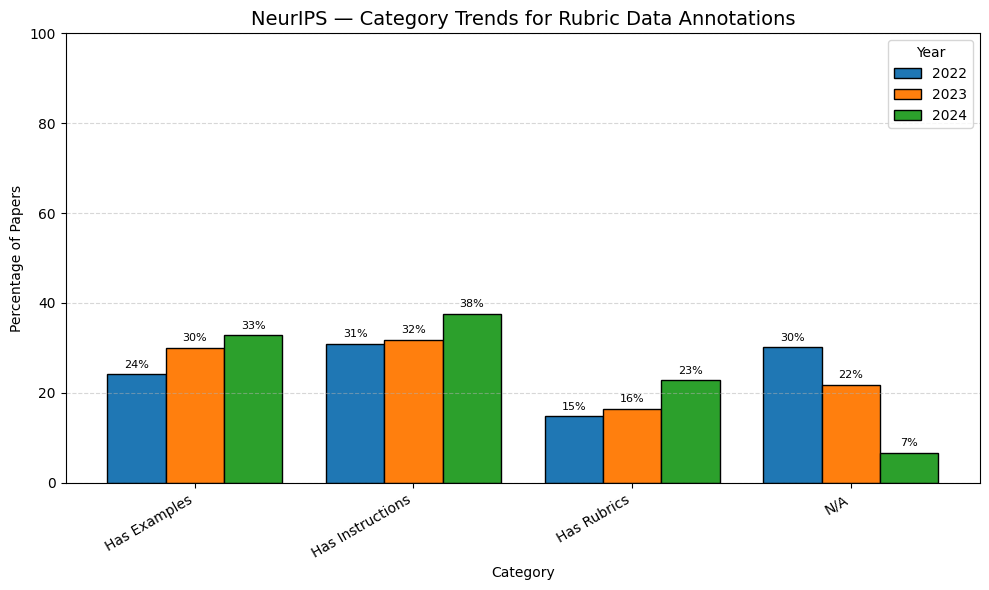

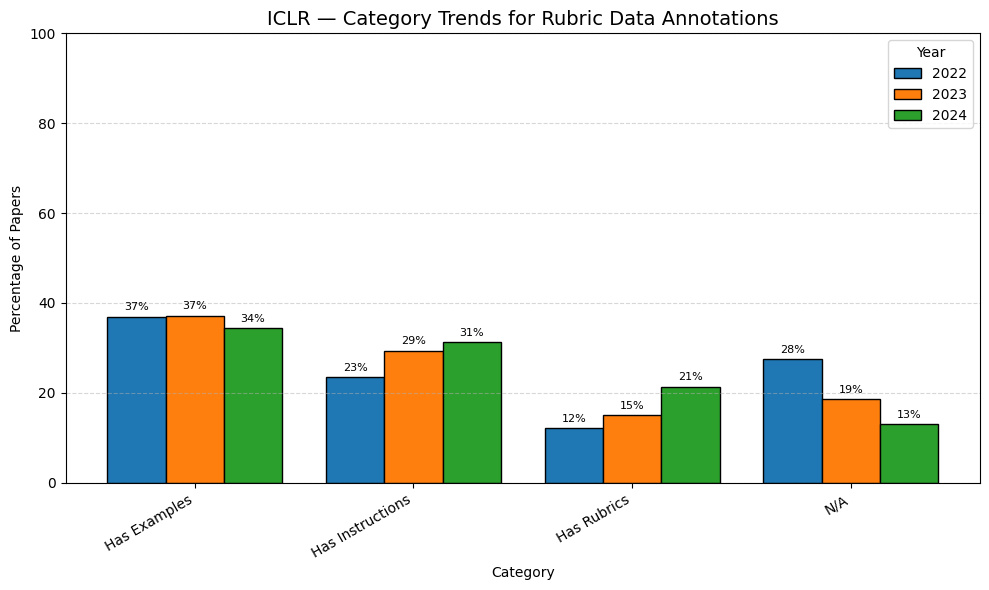

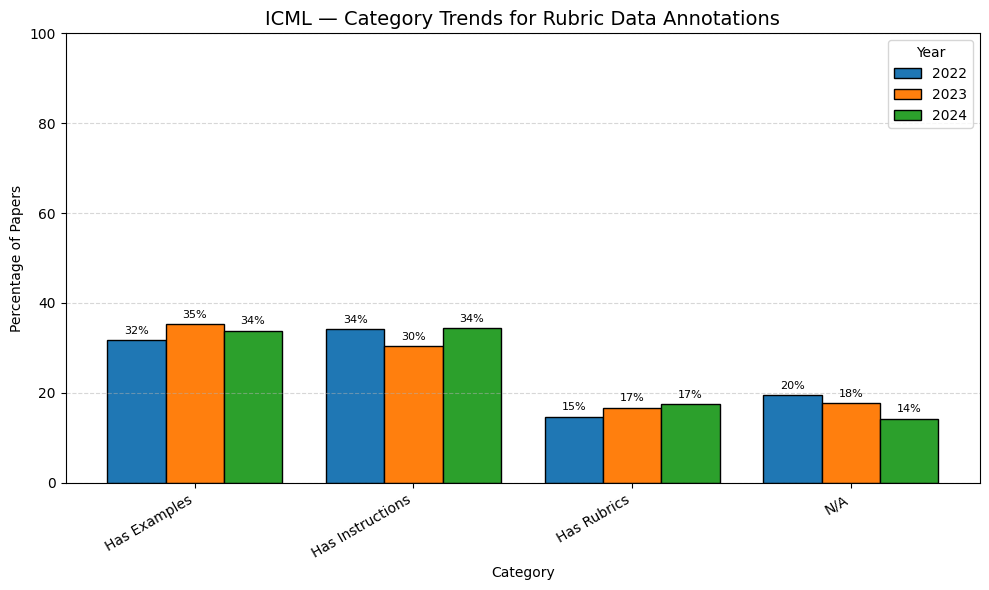

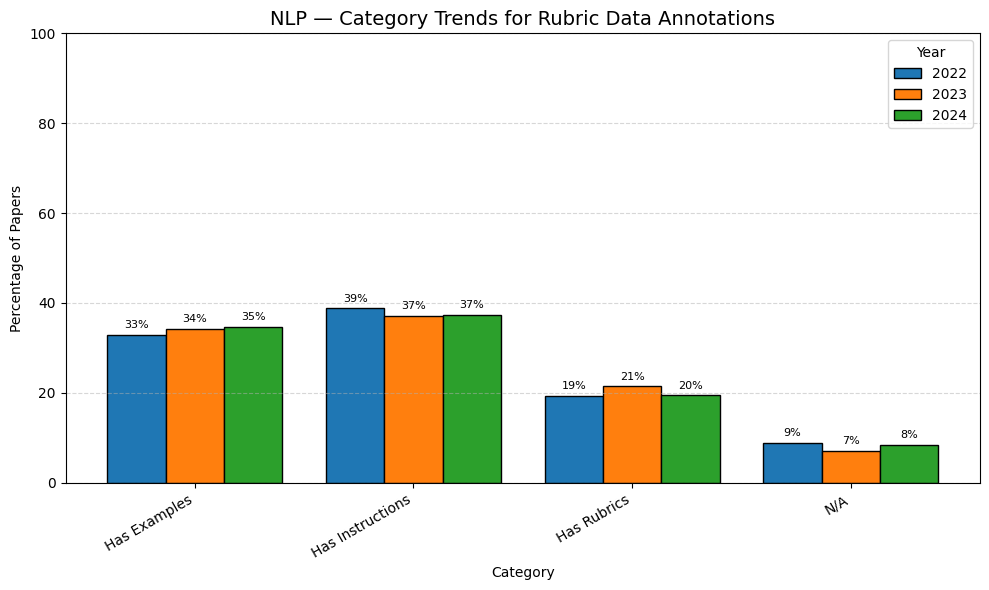

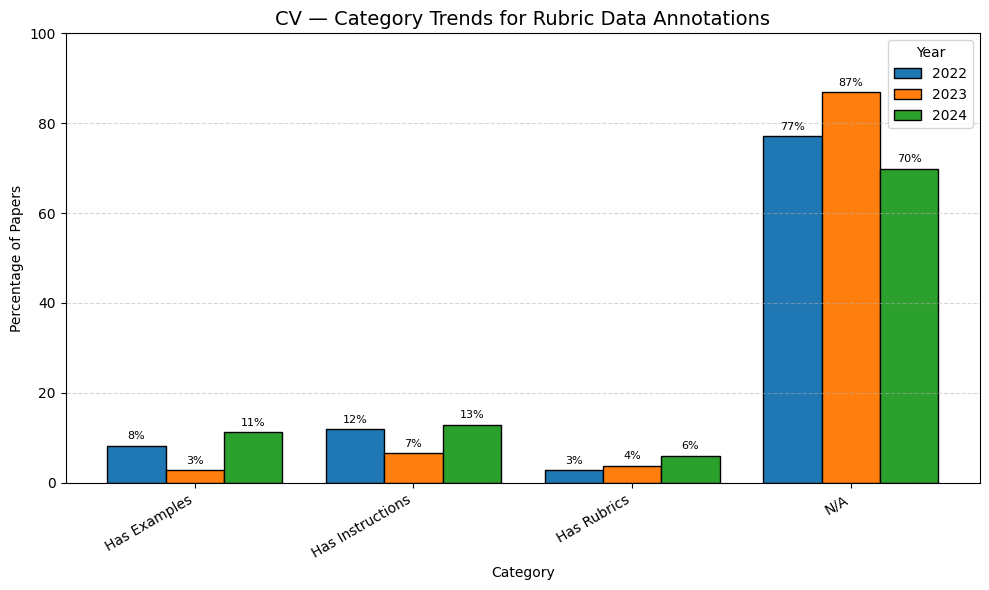

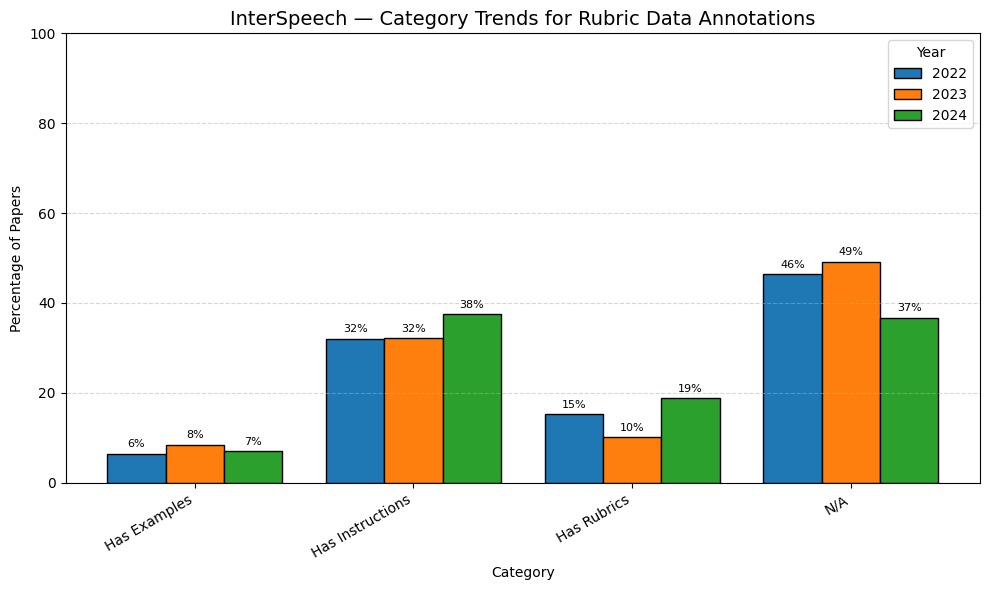

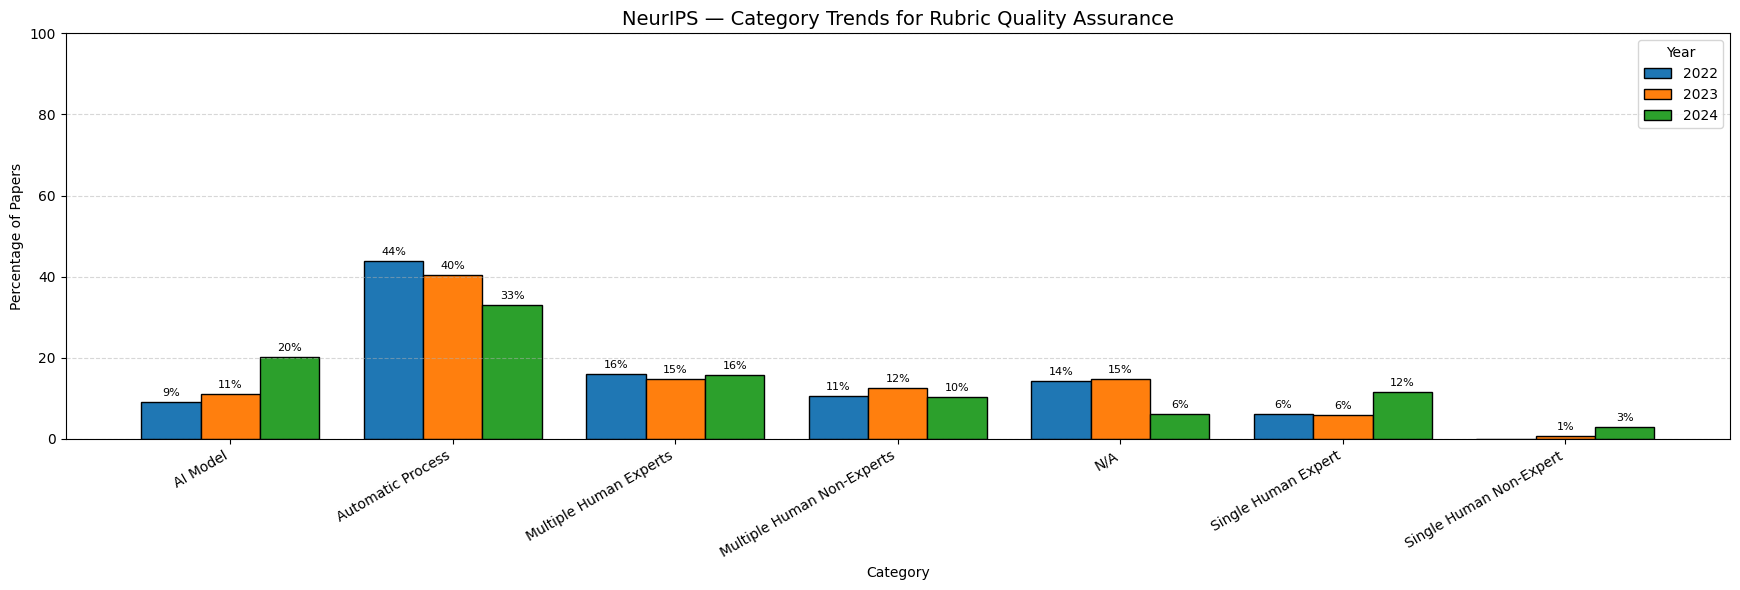

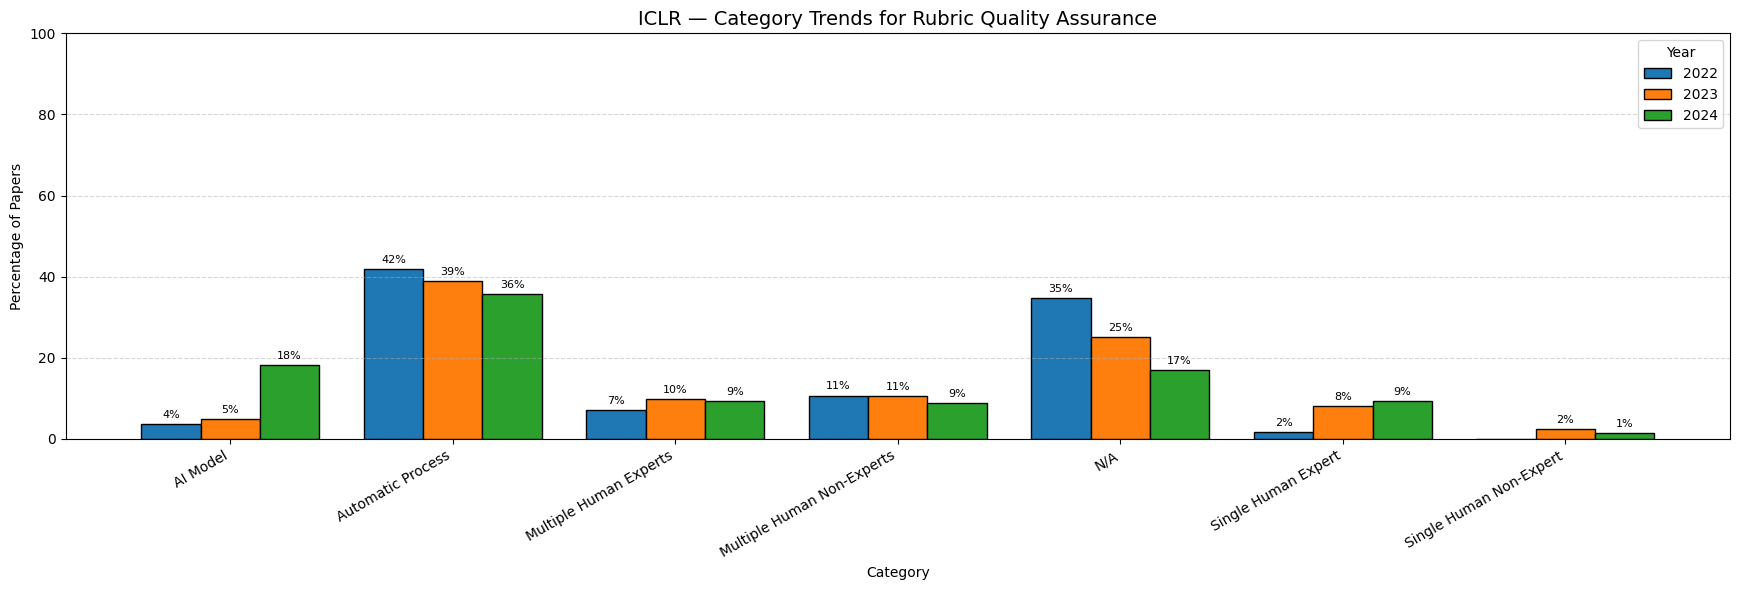

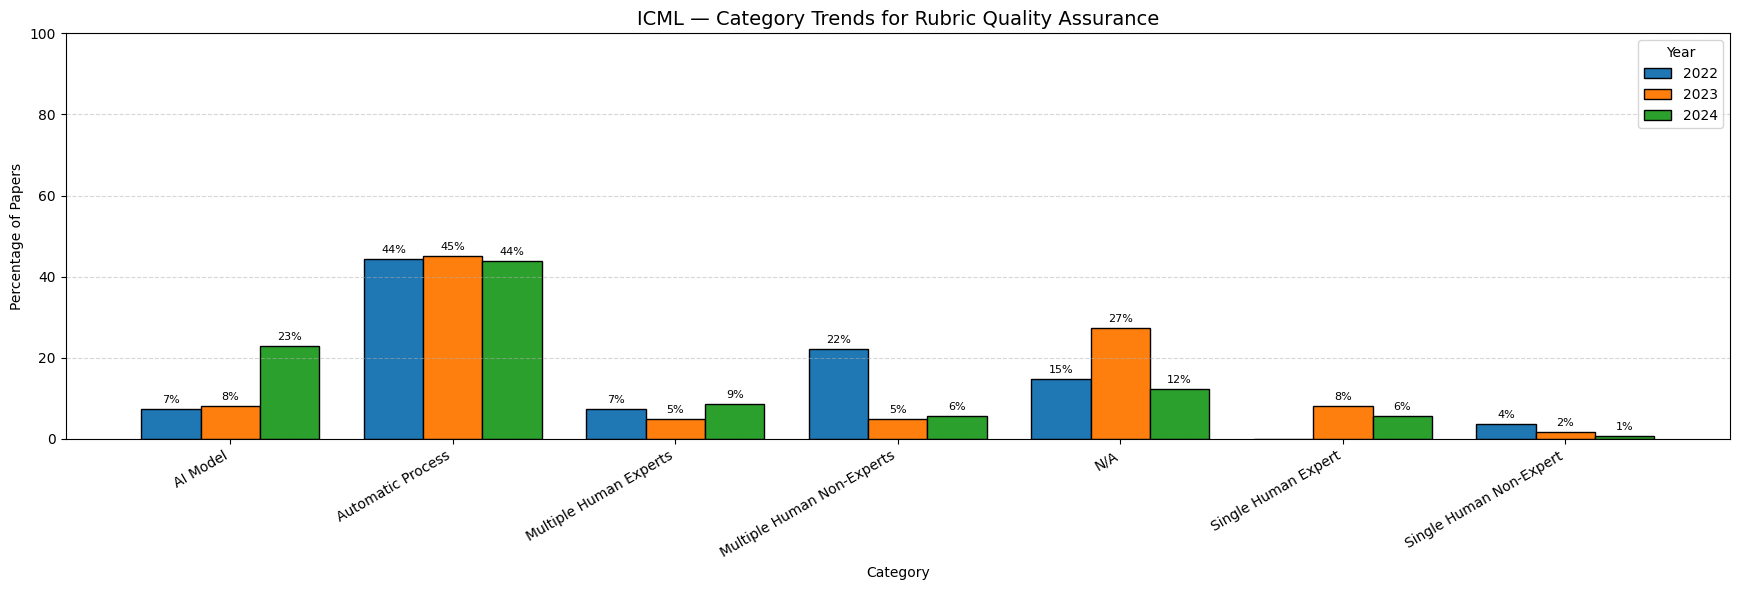

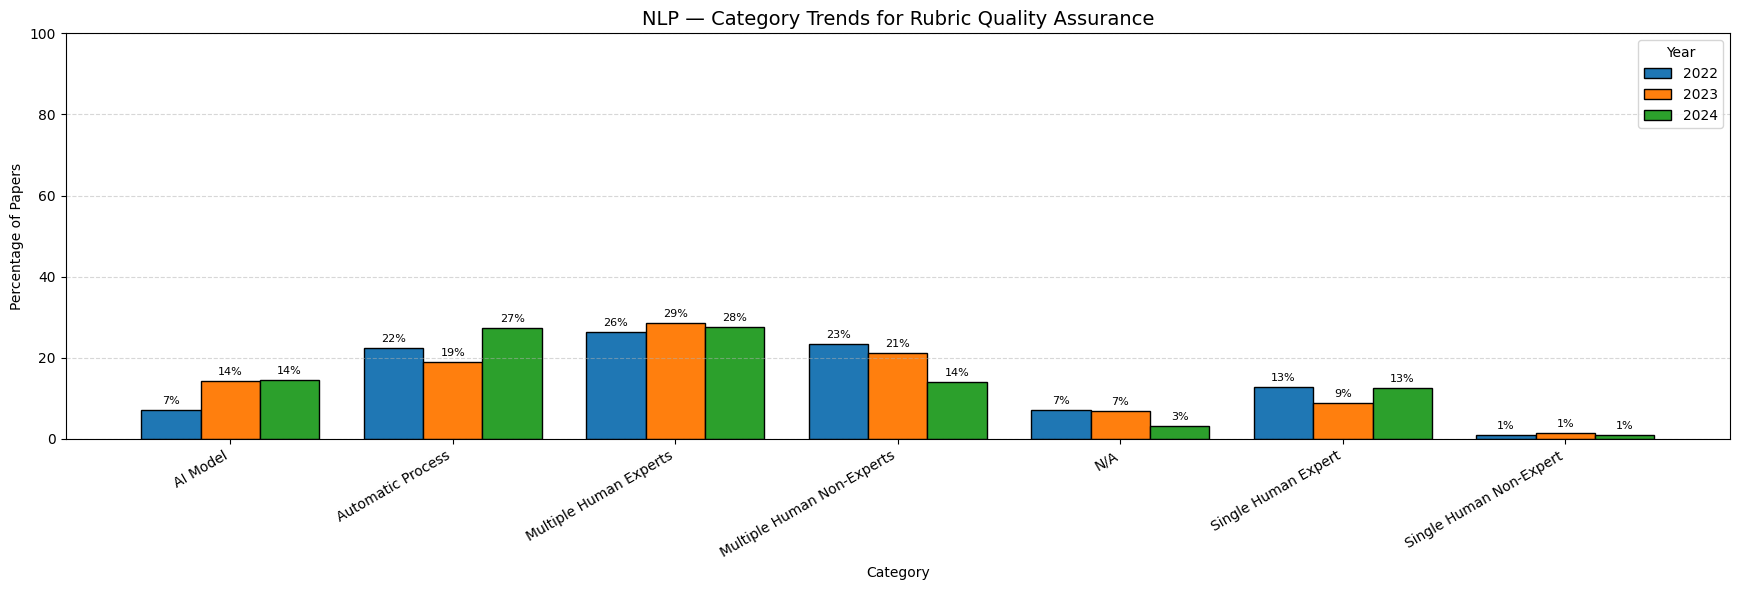

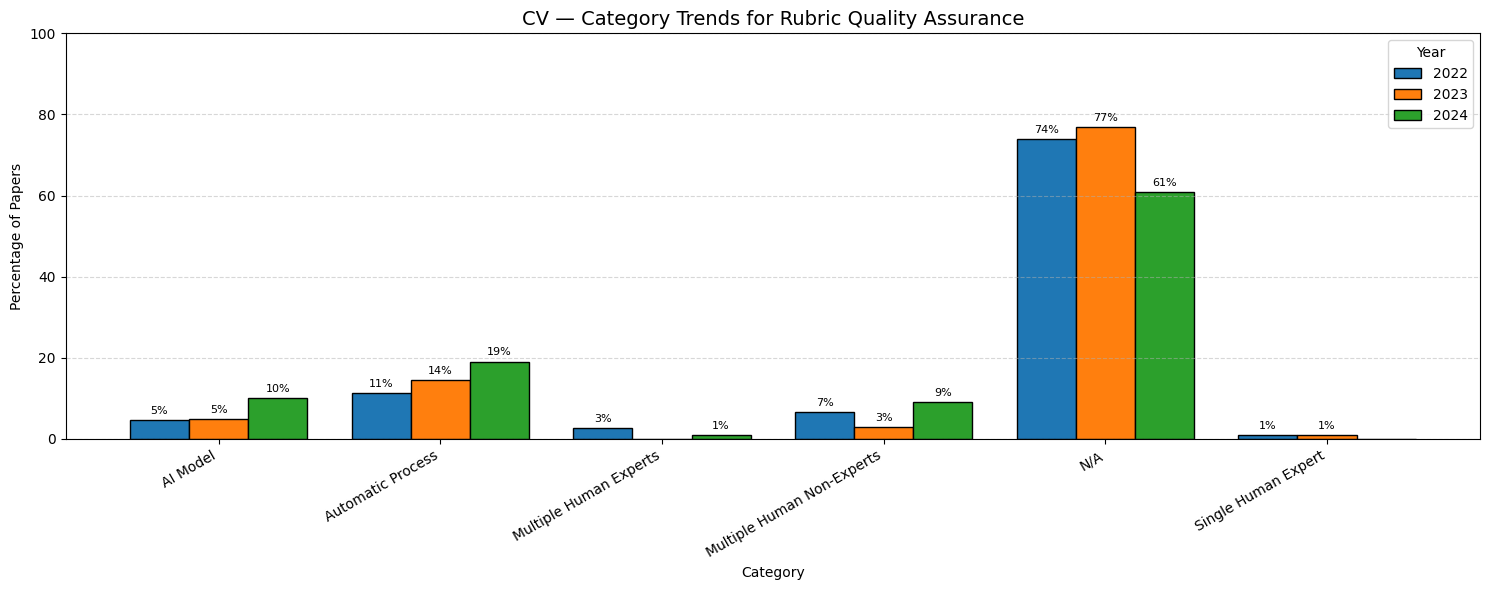

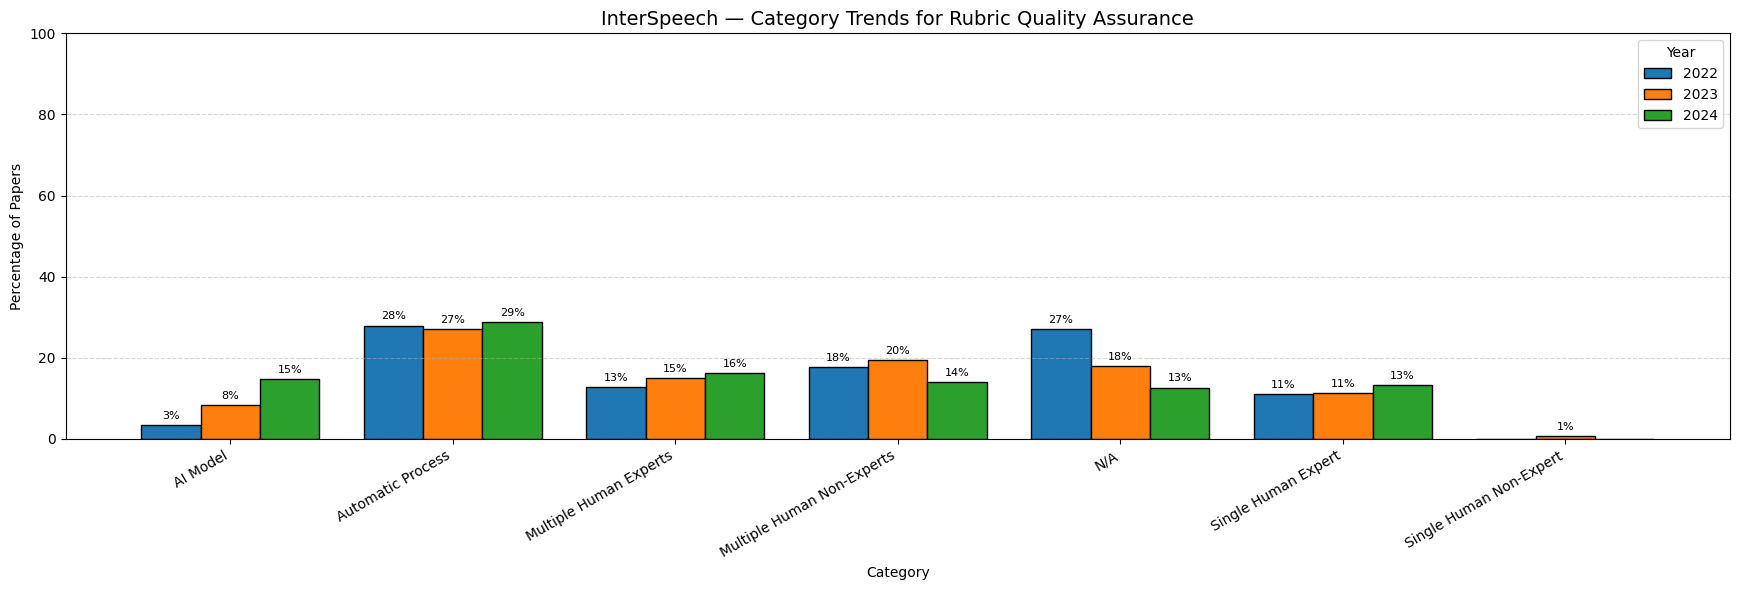

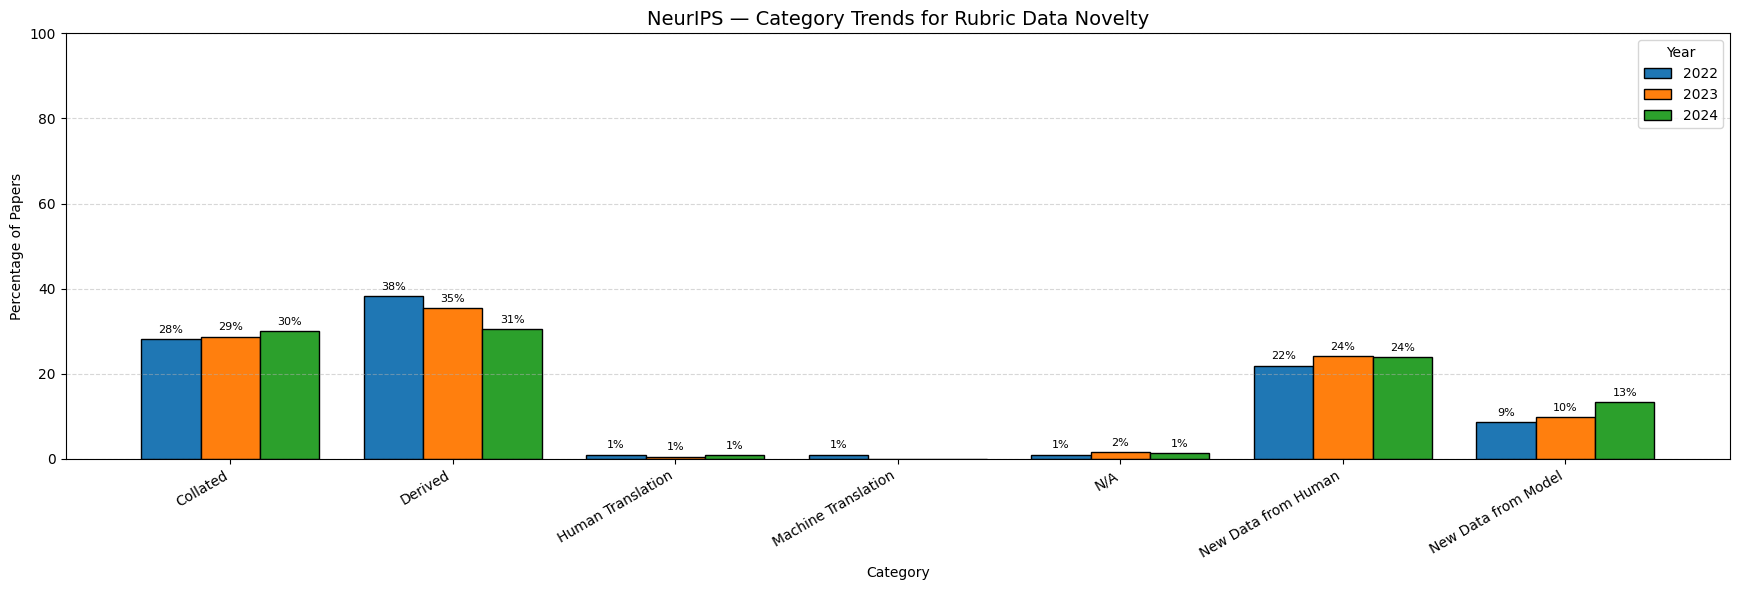

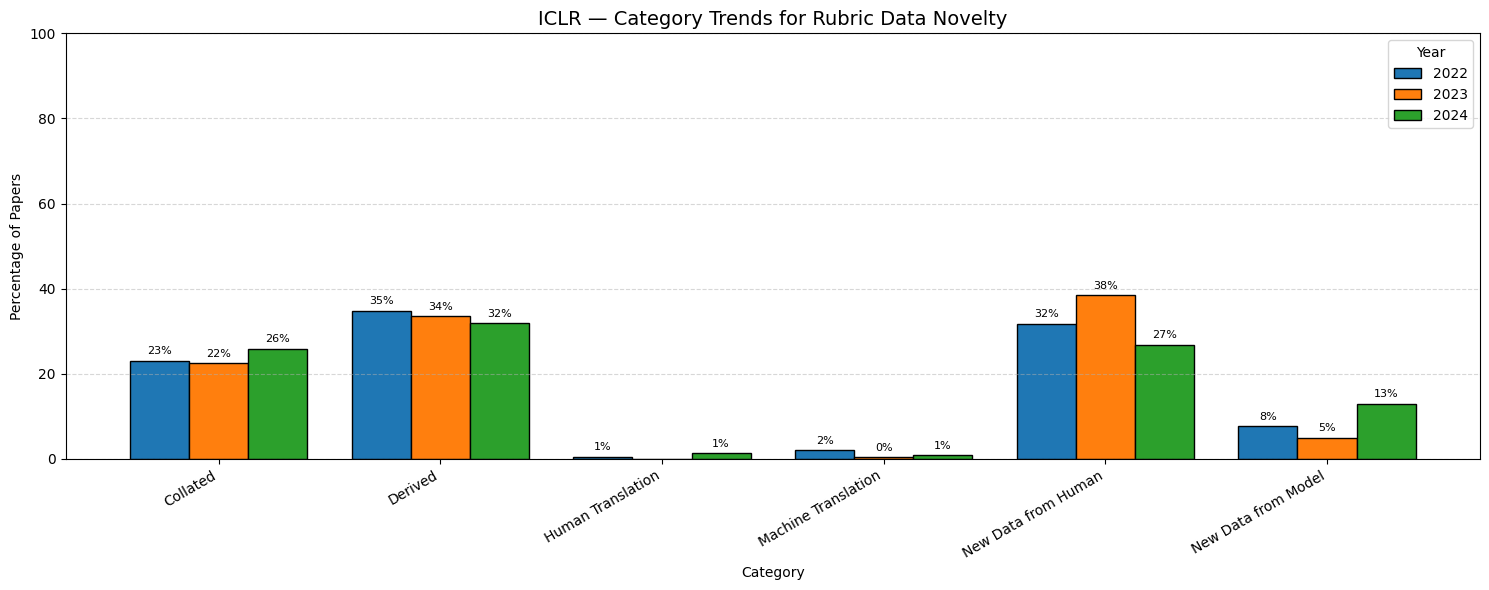

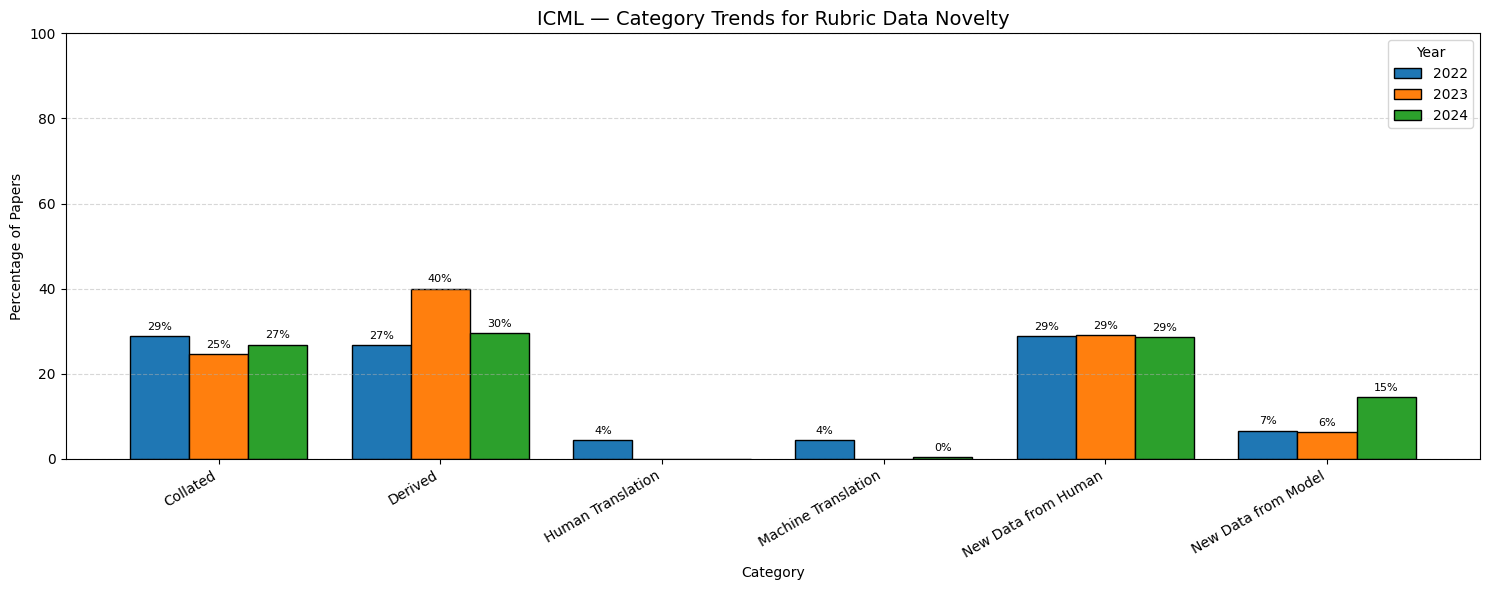

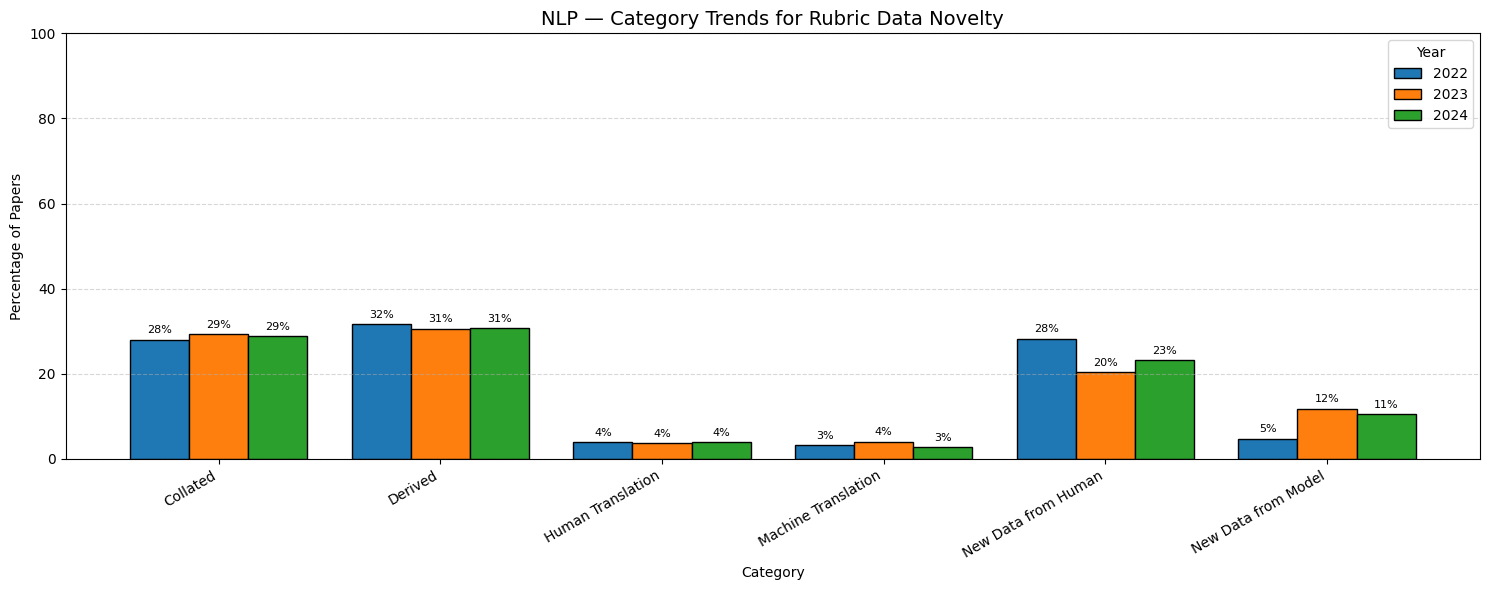

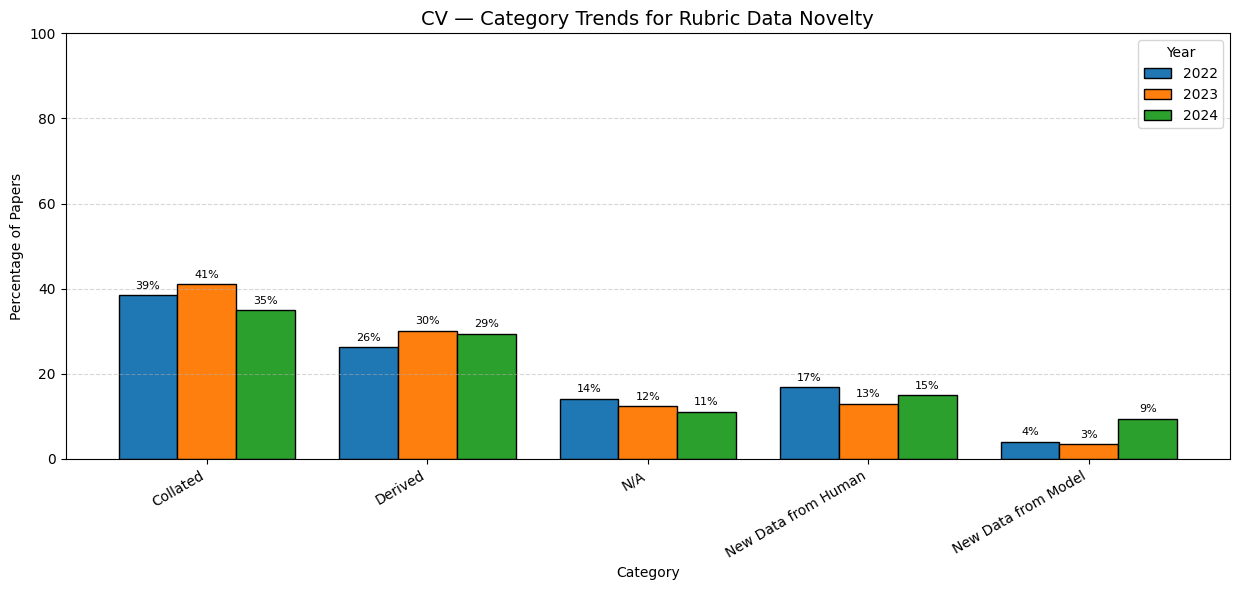

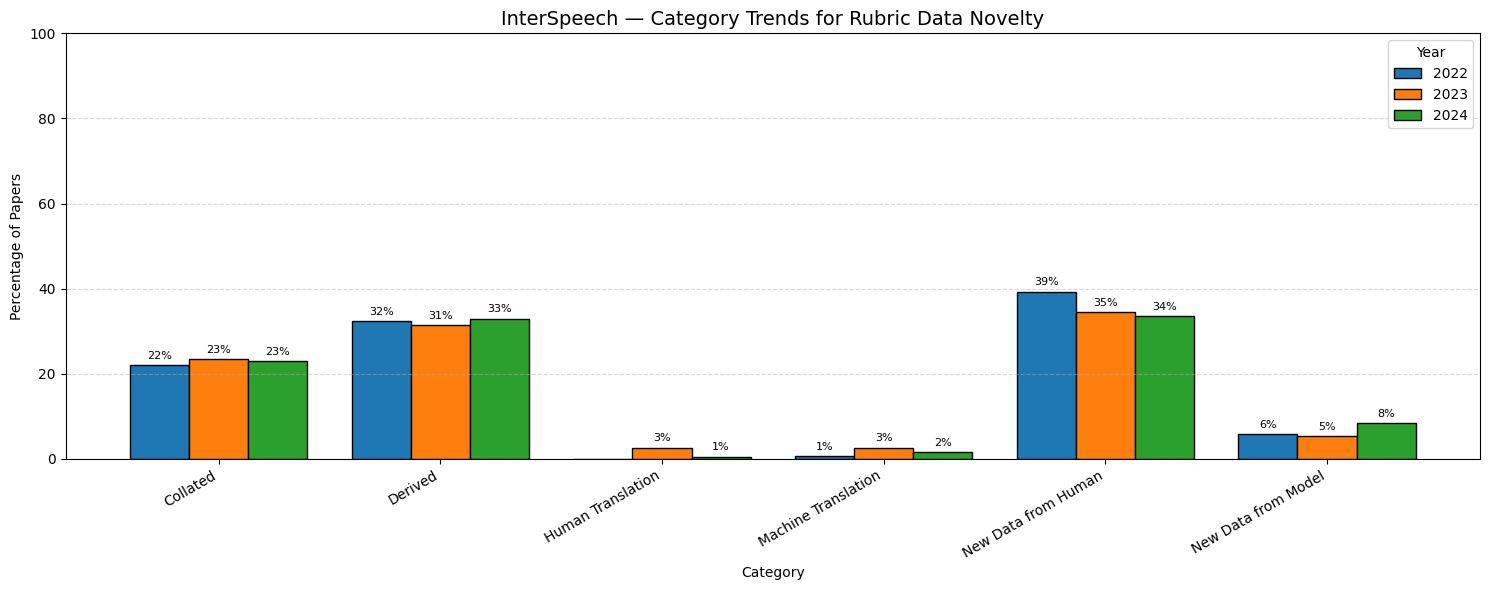

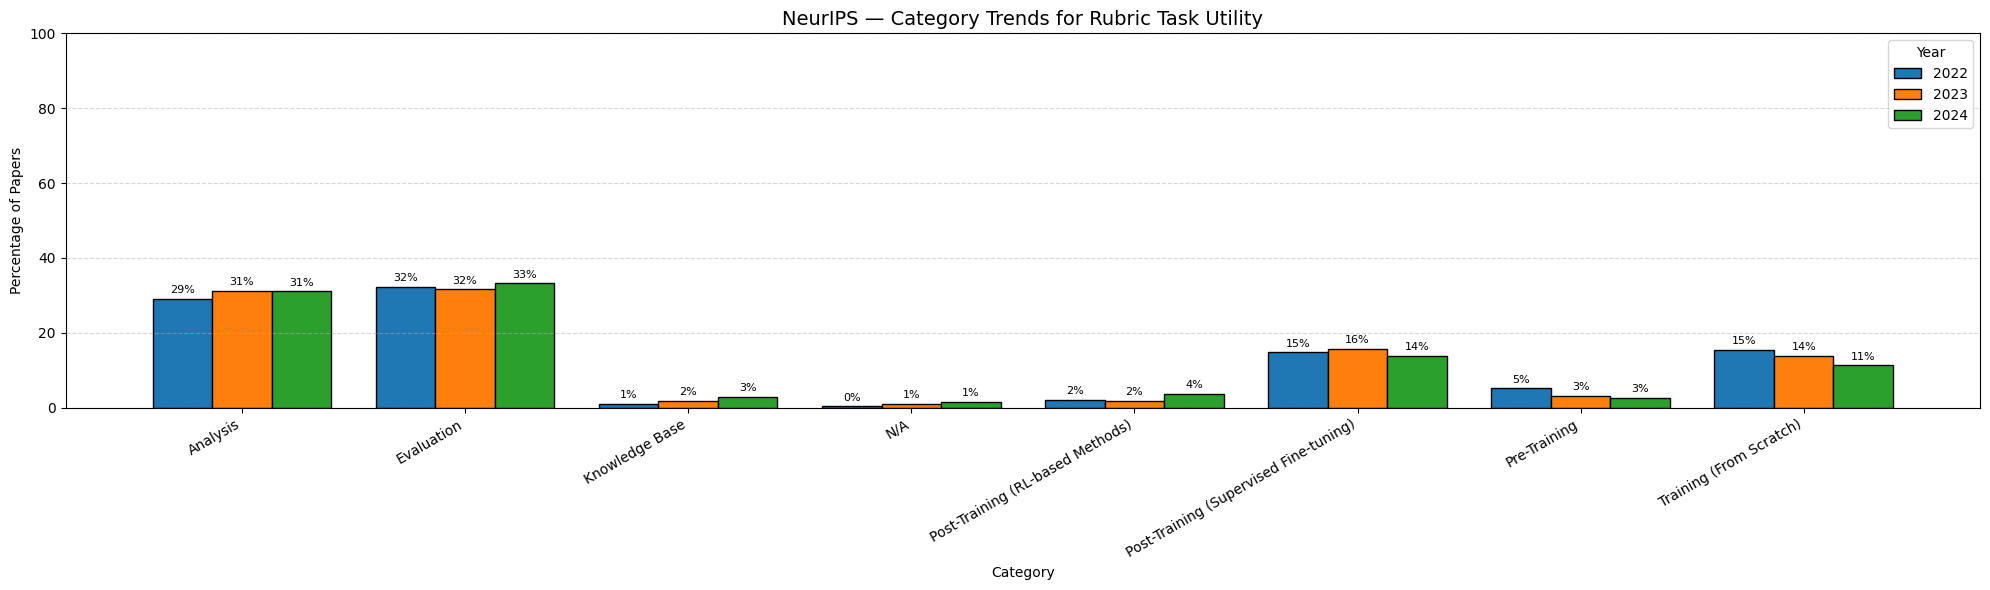

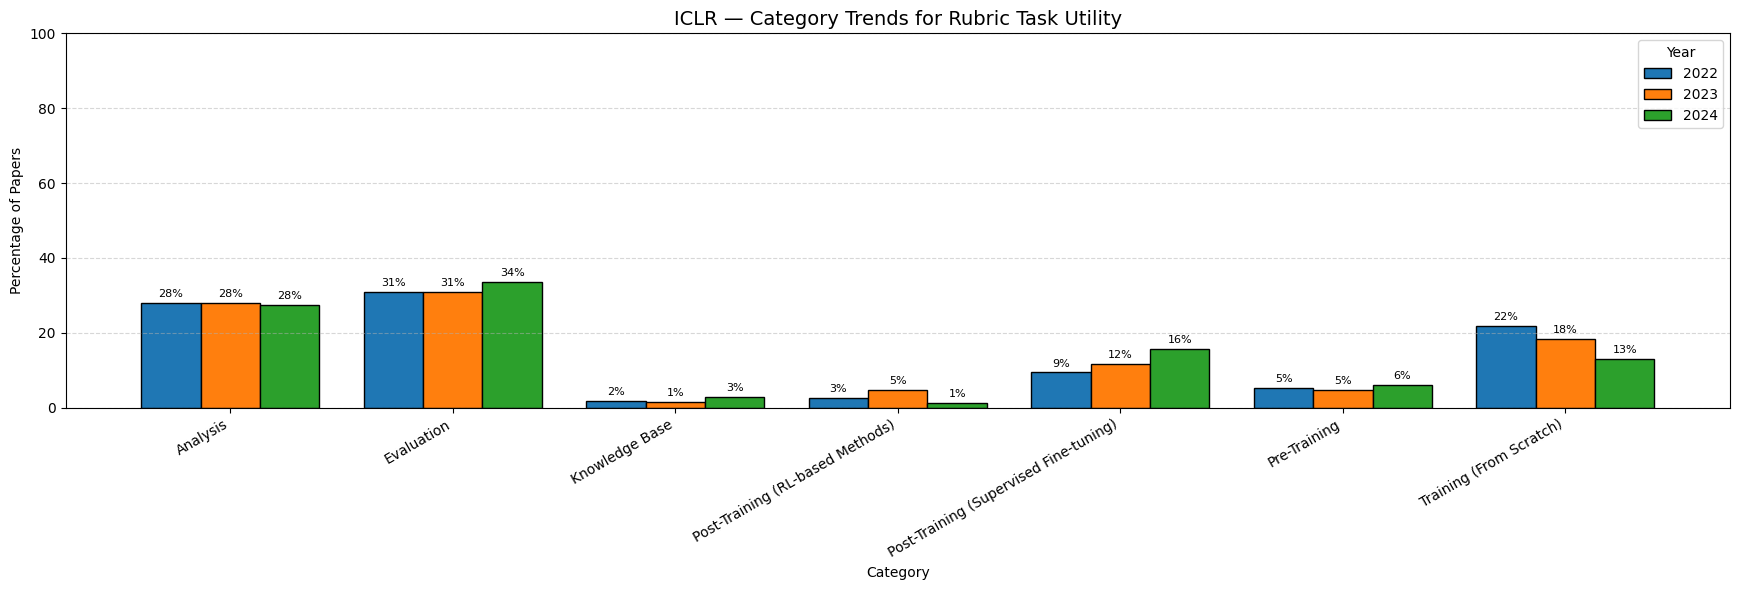

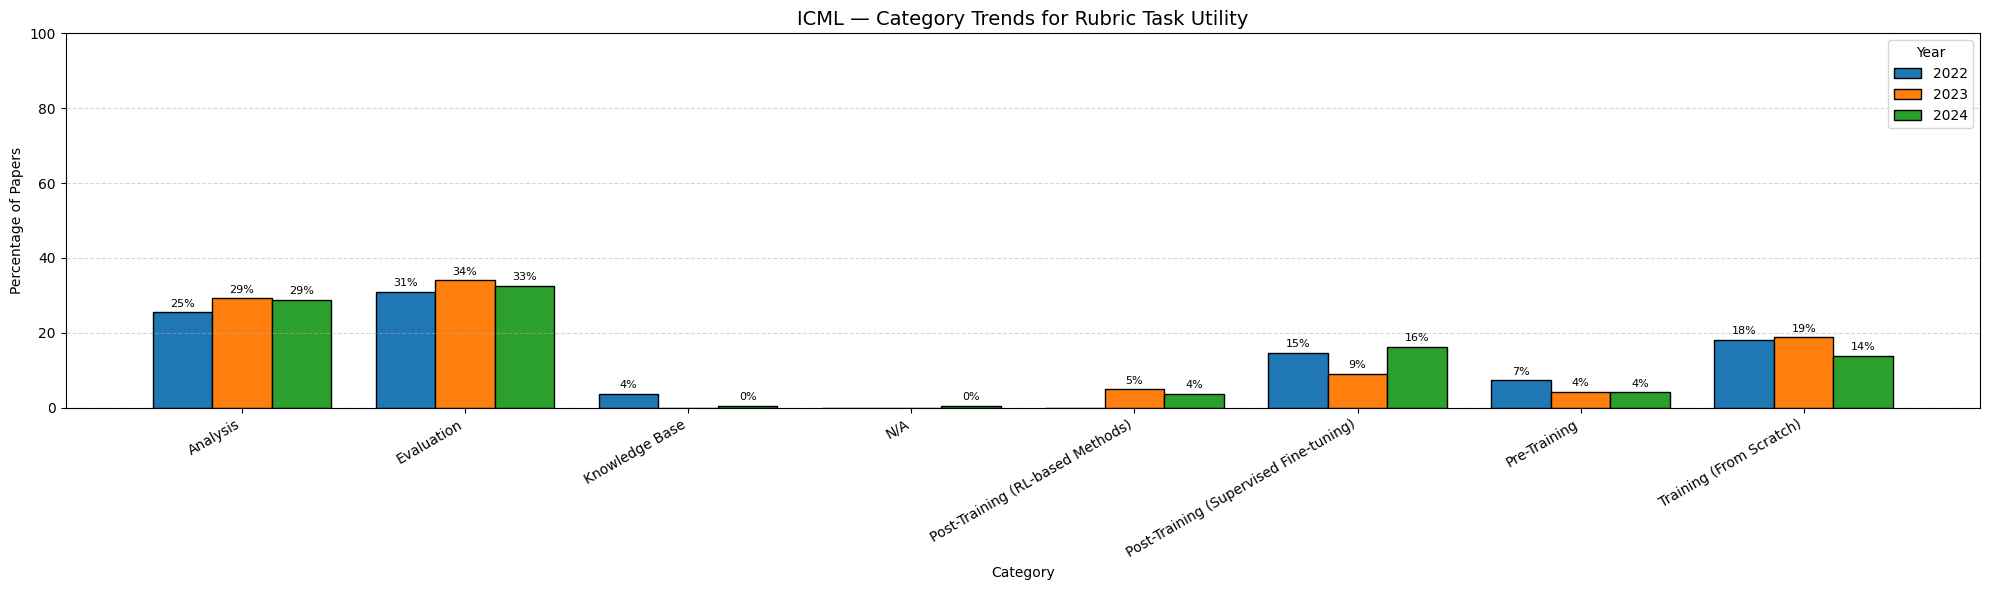

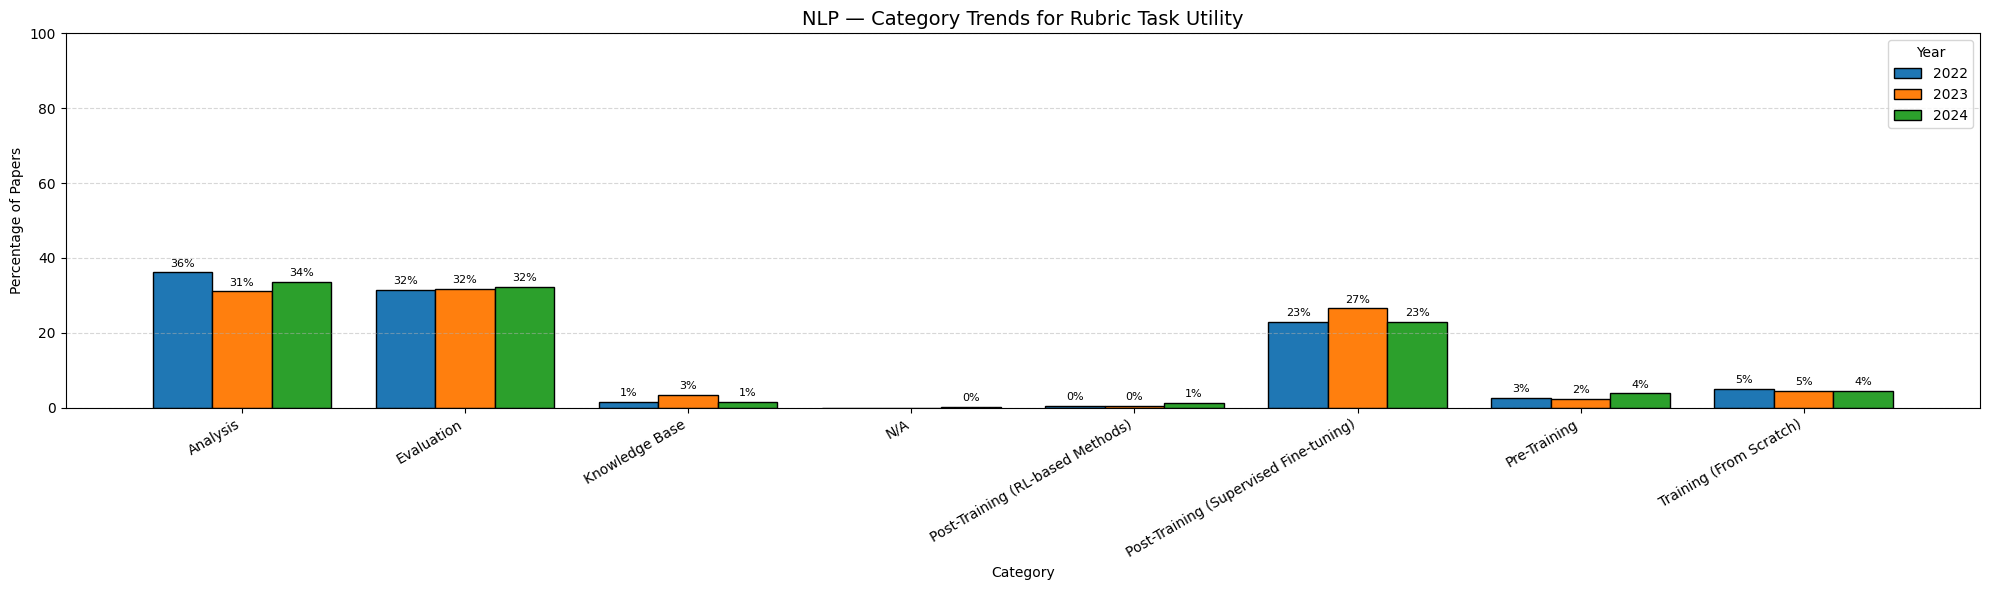

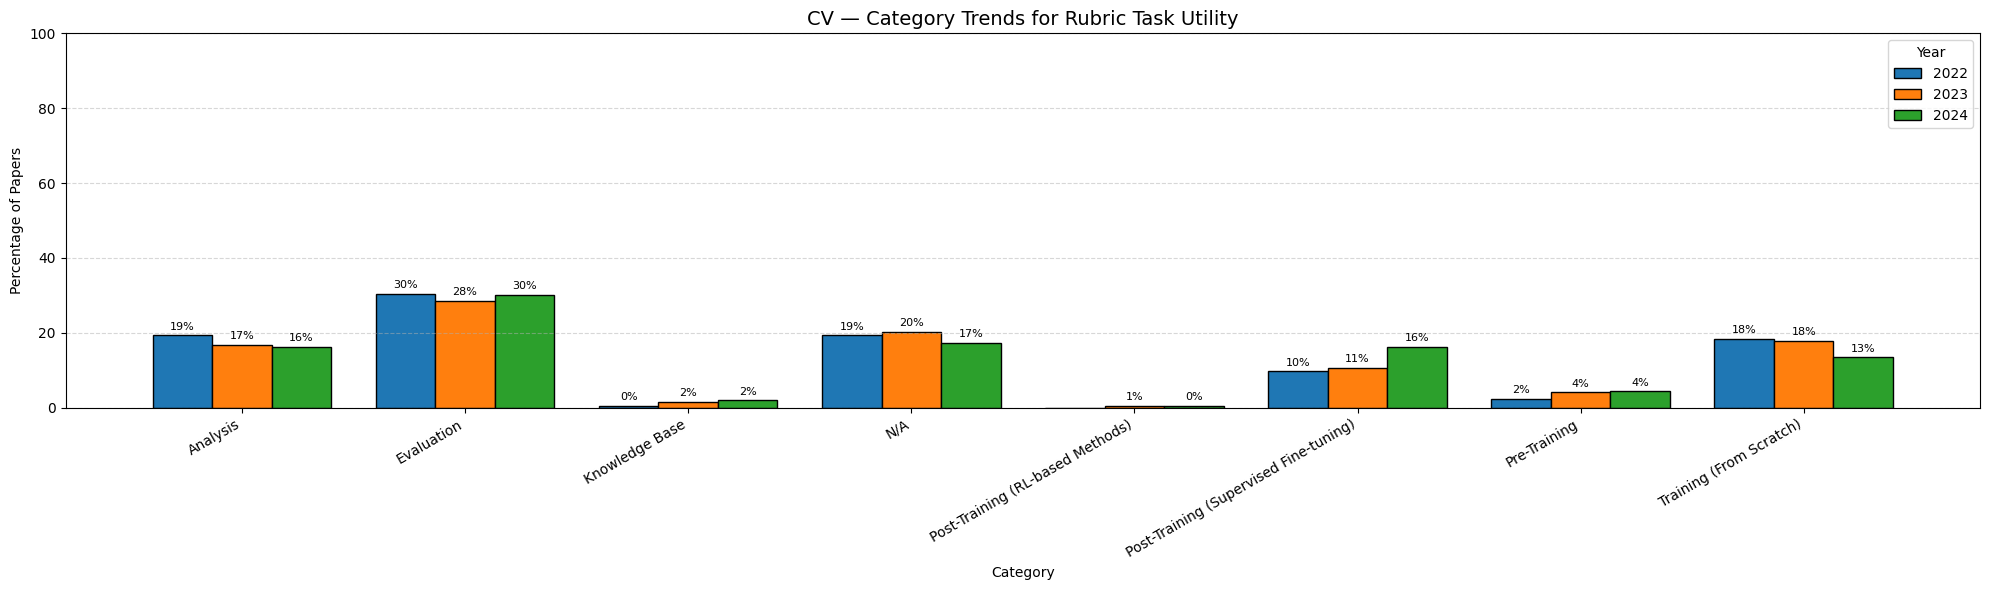

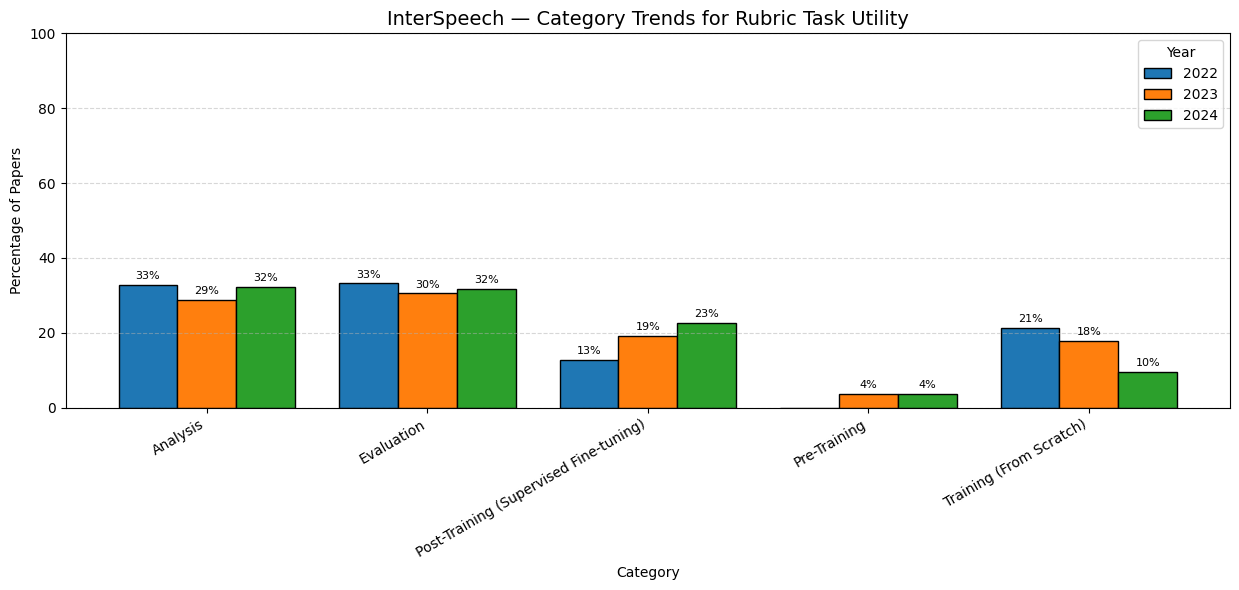

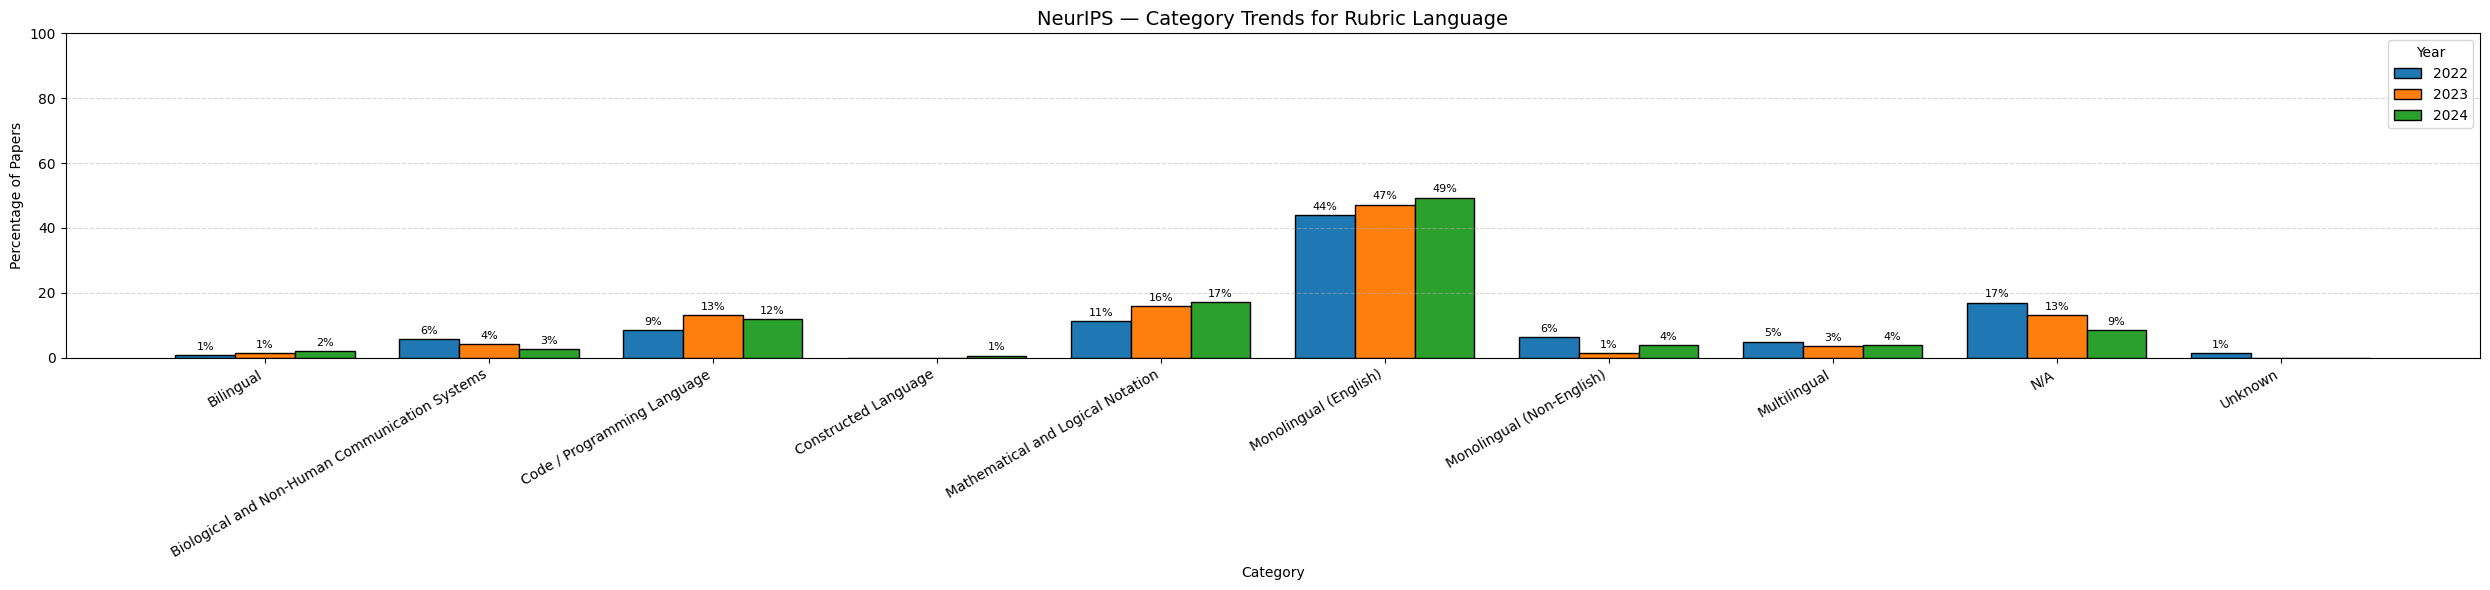

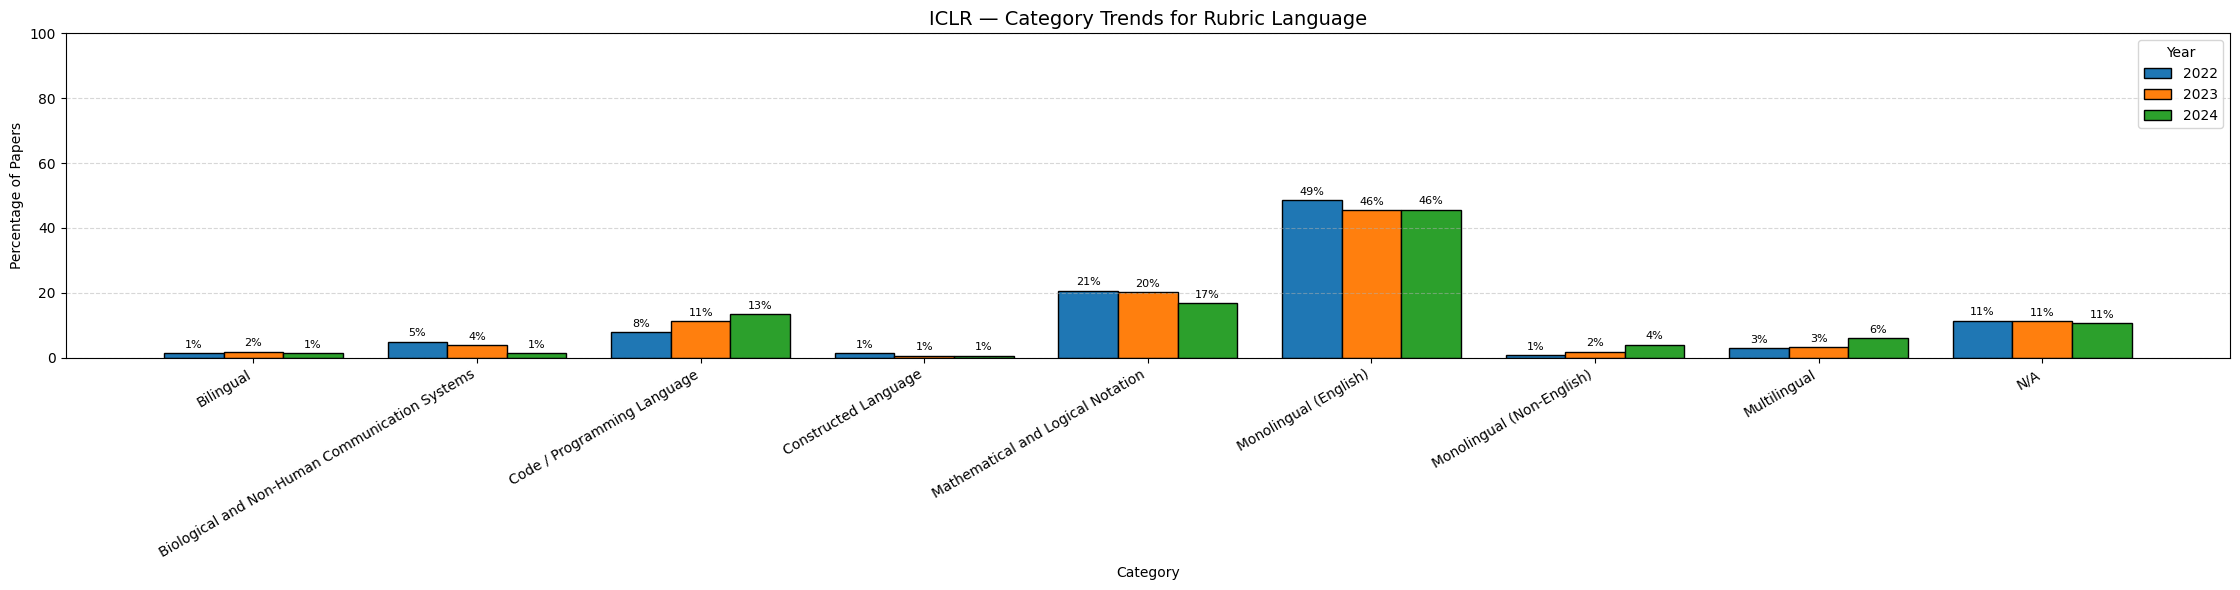

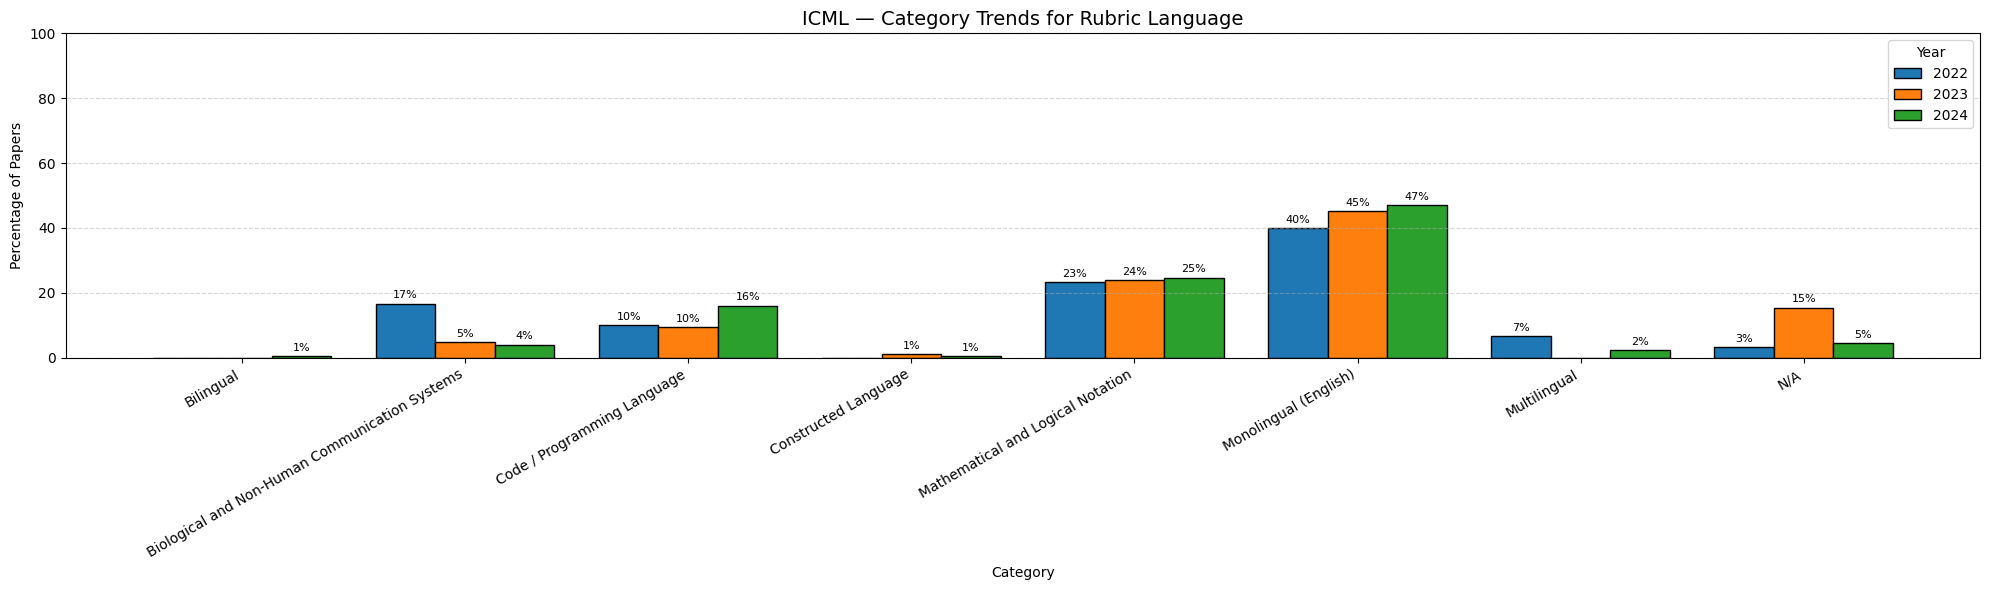

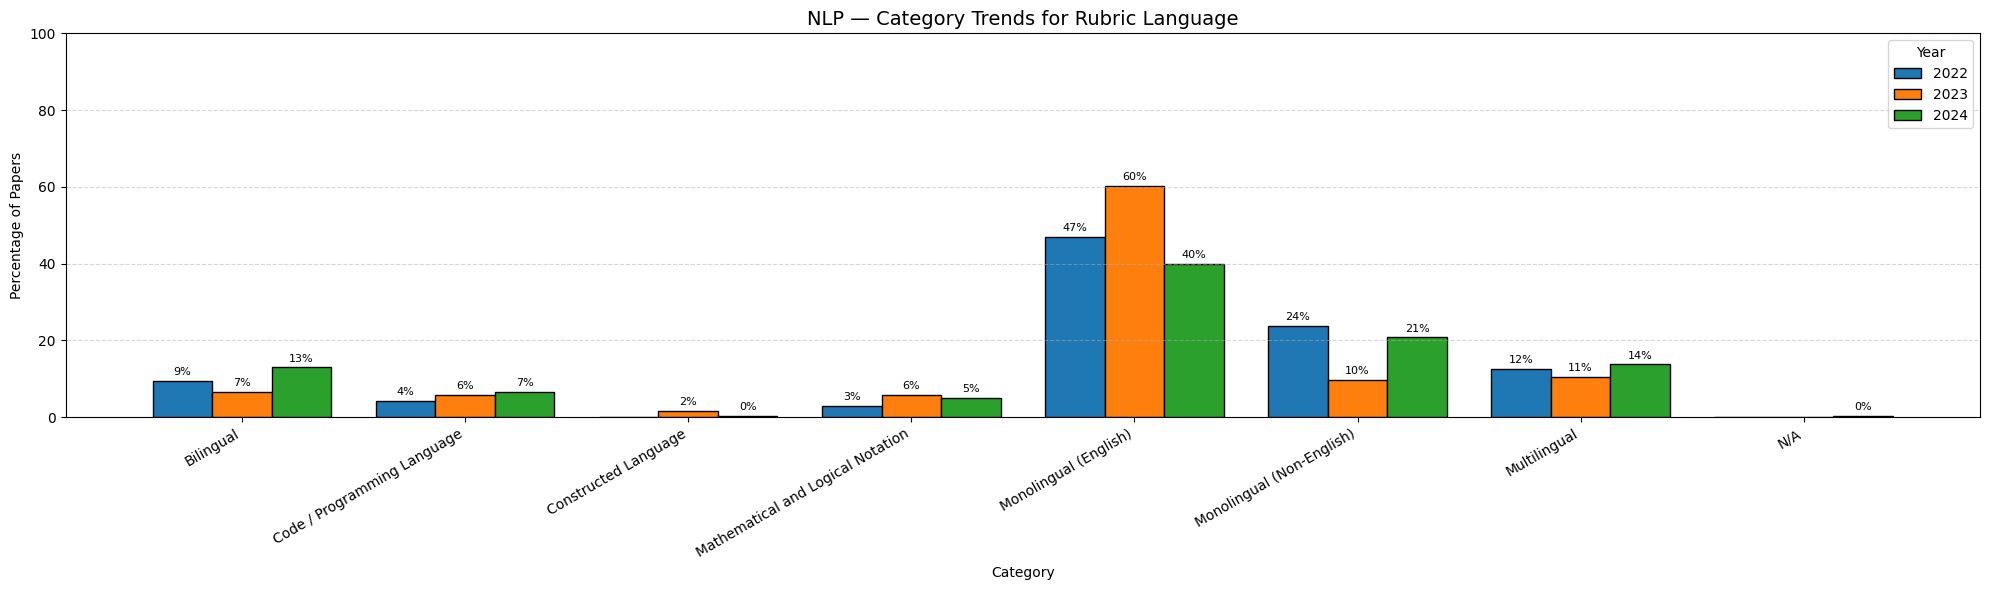

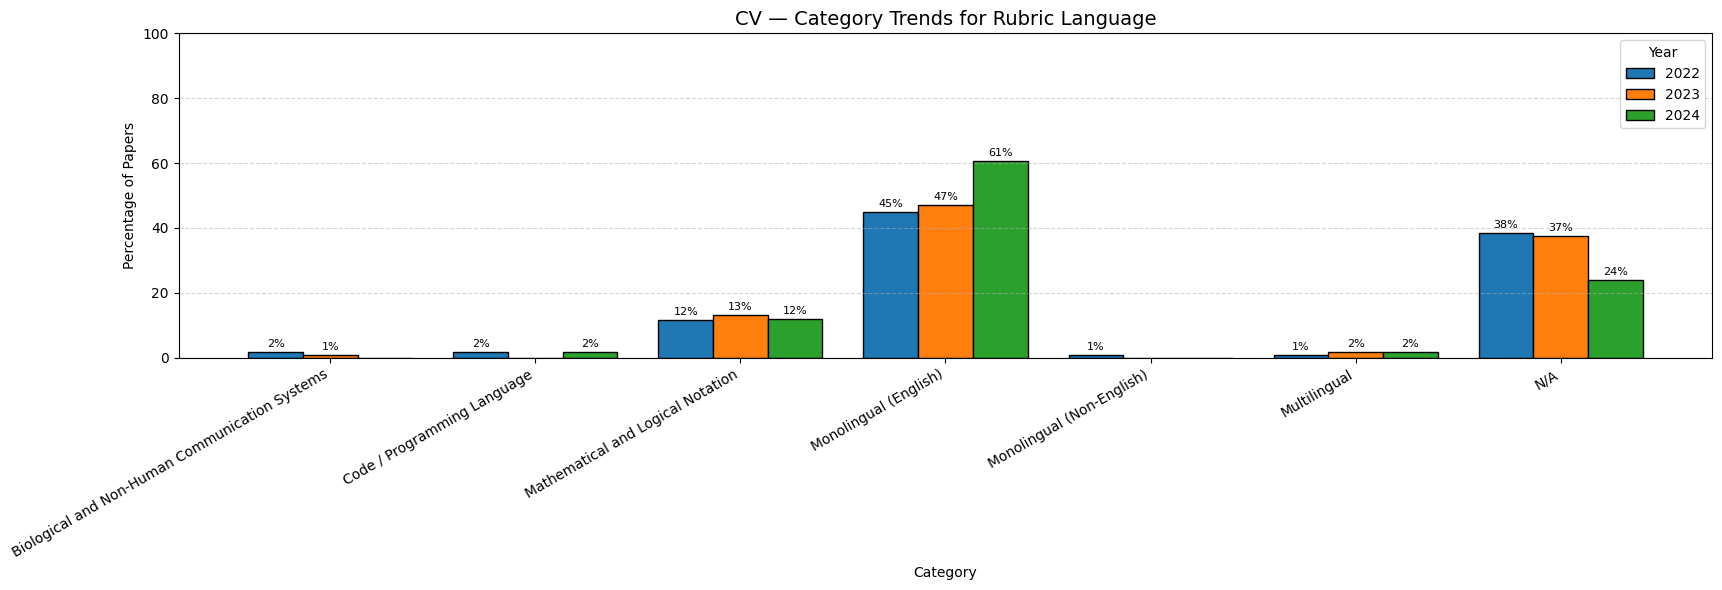

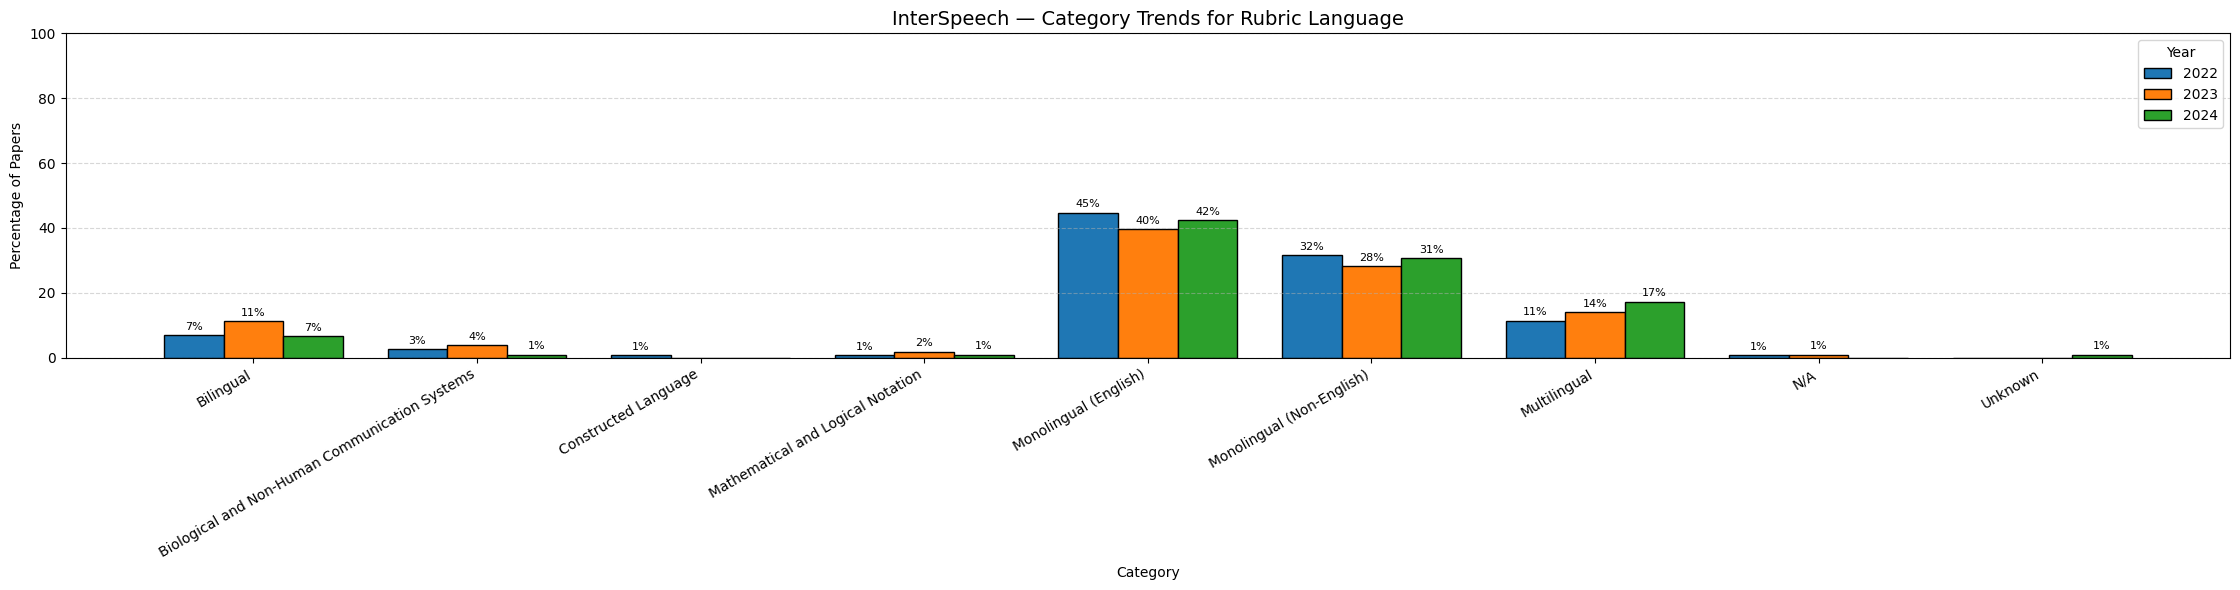

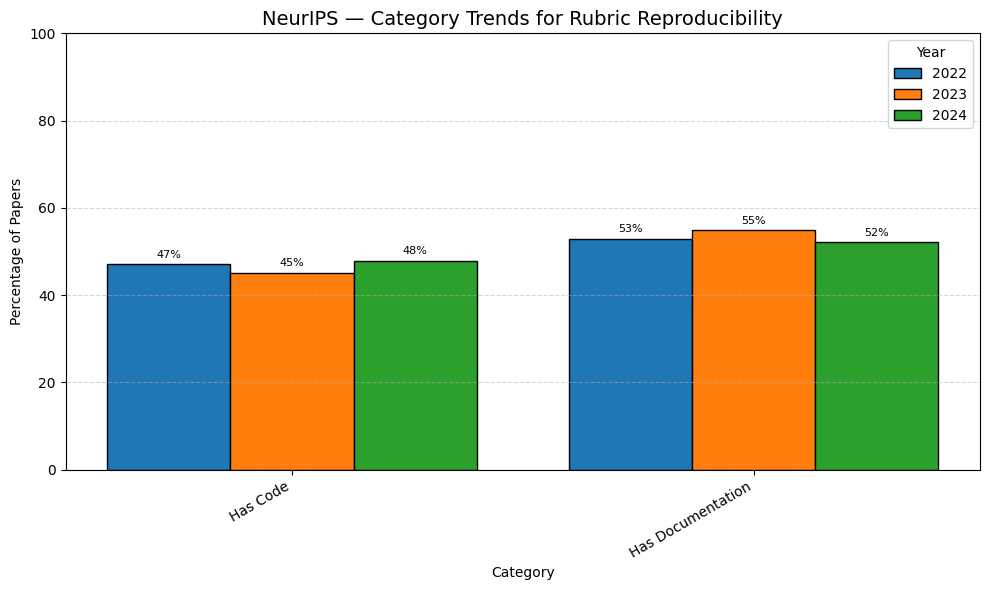

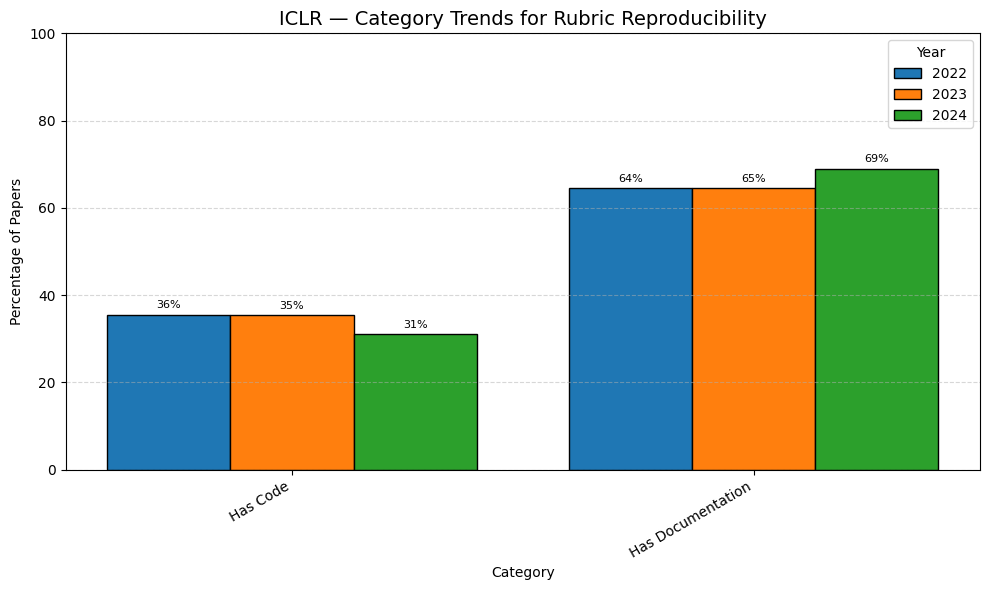

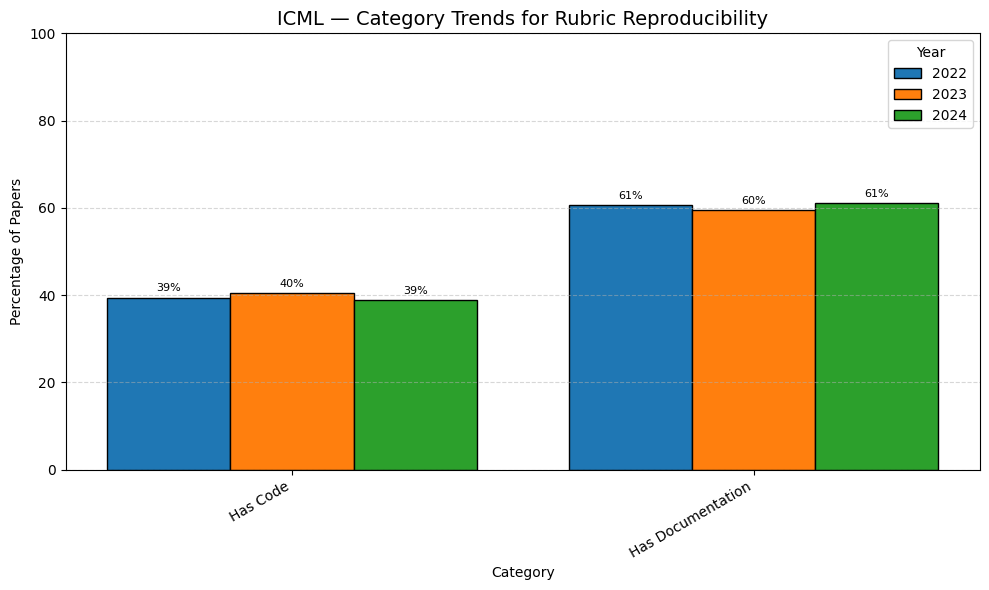

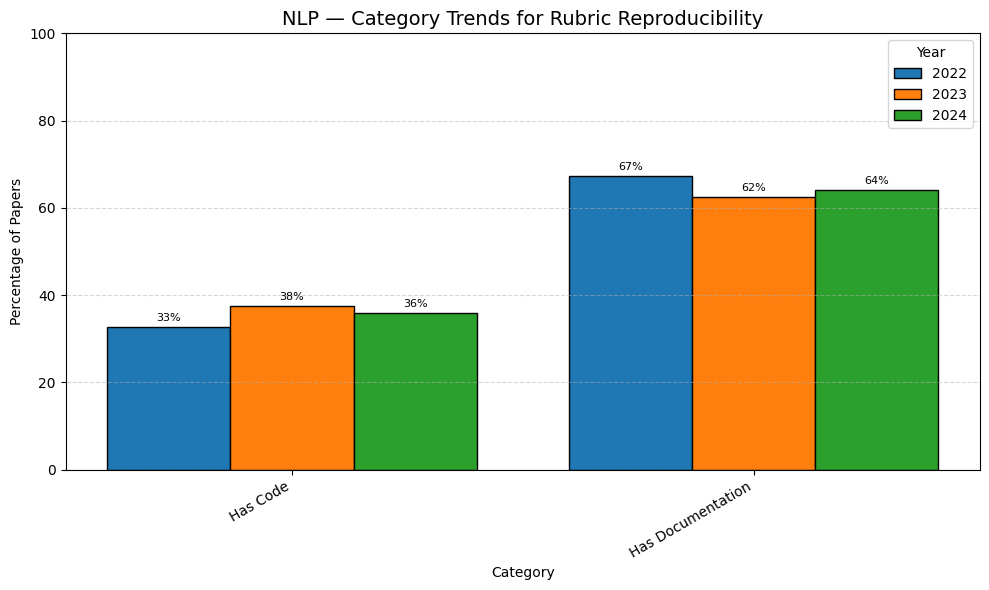

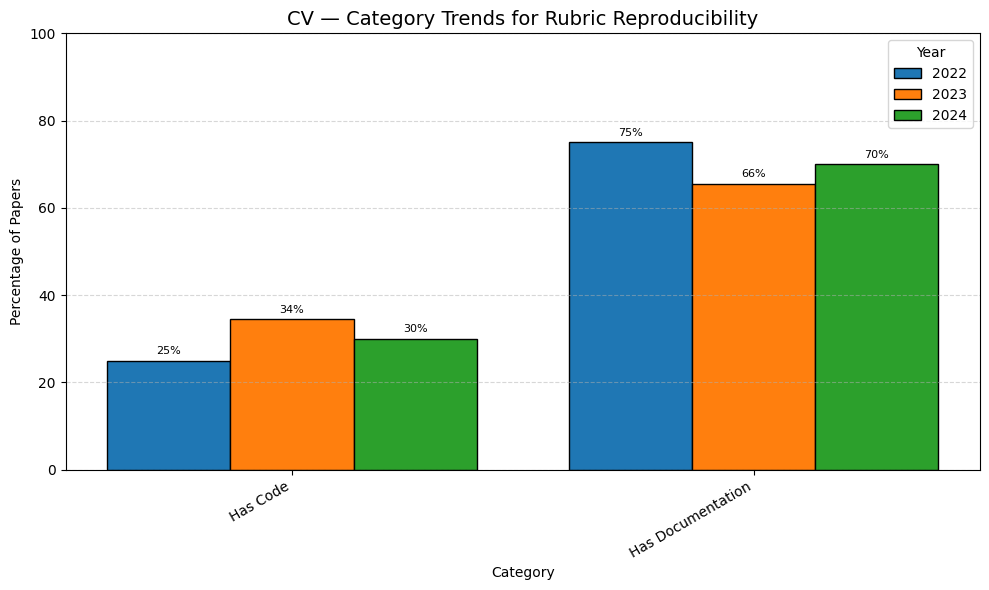

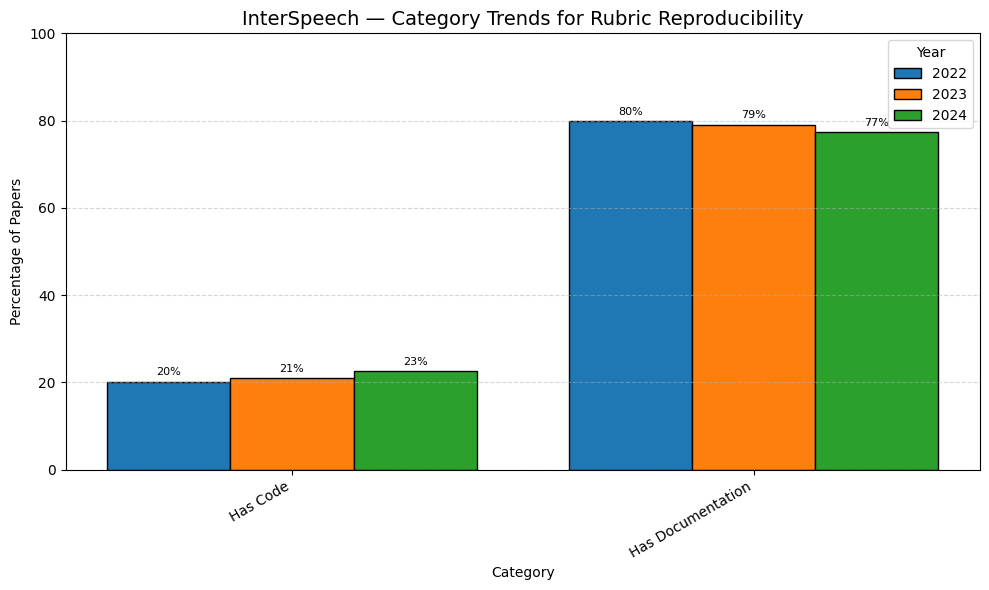

In [23]:
import json
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

titles = {
    'rubric-1': "Data Annotations",
    'rubric-2': "Quality Assurance",
    'rubric-3': "Data Novelty",
    'rubric-4': "Task Utility",
    'rubric-5': "Language",
    'rubric-6': "Reproducibility"
}

def analyze_specific_rubric_trends(json_filepaths, csv_filepaths, conference_names, target_rubrics):
    """
    Analyzes trends for specific rubrics across multiple conferences,
    aggregating all categories except 'N/A' into an 'All Other Categories (OR)' group.

    Args:
        json_filepaths (list): A list of file paths to the JSON files, one for each conference.
        csv_filepaths (list): A list of file paths to the CSV files, one for each conference.
        conference_names (list): A list of names for each conference, corresponding to file paths.
        target_rubrics (list): A list of rubric IDs (e.g., ['rubric-1', 'rubric-2'])
                                for which to apply the specific aggregation logic.

    Returns:
        dict: A nested dictionary containing yearly counts for 'N/A' and
              'All Other Categories (OR)', grouped by conference name and then by target rubric ID.
              Structure: {conference_name: {rubric_id: {year: {'N/A': count, 'All Other Categories (OR)': count}}}}.
    """
    print(len(json_filepaths))
    if not (len(json_filepaths) == len(csv_filepaths) == len(conference_names)):
        print("Error: The lists of JSON file paths, CSV file paths, and conference names must be of the same length.")
        return {}

    all_conferences_rubric_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))

    for conf_idx, conf_name in enumerate(conference_names):
        json_filepath = json_filepaths[conf_idx]
        csv_filepath = csv_filepaths[conf_idx]

        print(f"Processing data for conference: {conf_name}")

        # Load the CSV content using pandas
        try:
            csv_df = pd.read_csv(csv_filepath)
            id_to_year = csv_df.set_index('id')['year'].astype(str).to_dict()
        except FileNotFoundError:
            print(f"Error: CSV file not found at {csv_filepath} for {conf_name}. Skipping this conference.")
            continue
        except KeyError:
            print(f"Error: 'id' or 'year' column not found in CSV file {csv_filepath} for {conf_name}. Skipping this conference.")
            continue
        except Exception as e:
            print(f"Error loading or processing CSV file {csv_filepath} for {conf_name}: {e}. Skipping this conference.")
            continue

        # Load the JSON content using json.load
        try:
            with open(json_filepath, 'r') as f:
                json_data = json.load(f)
        except FileNotFoundError:
            print(f"Error: JSON file not found at {json_filepath} for {conf_name}. Skipping this conference.")
            continue
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from {json_filepath} for {conf_name}. Check file format. Skipping this conference.")
            continue
        except Exception as e:
            print(f"Error loading JSON file {json_filepath} for {conf_name}: {e}. Skipping this conference.")
            continue

        # Process data for the current conference
        for entry in json_data:
            full_json_id = entry.get('id')
            base_json_id = "-".join(full_json_id.split("-")[:-2])
            rubric_id = "-".join(full_json_id.split("-")[-2:])

            # Only process if the rubric_id is one of the target rubrics
            if rubric_id == "rubric-1" or rubric_id == "rubric-6":
                year = id_to_year.get(base_json_id)
                if year:
                    try:
                        year = int(year)
                    except ValueError:
                        continue
                    
                    response_data = entry.get('response', {})
                    if not response_data:
                        continue
                    
                    if rubric_id == "rubric-1":
                        section_content = response_data["data_annotations"]
                        if len(section_content) == 0:
                            all_conferences_rubric_data[conf_name][rubric_id][year]["N/A"] += 1
                        else:
                            for content in section_content:
                                found_guidelines = False
                                if "Automatic Process" != content["Subject Annotators"]:
                                    for key in content:
                                        if key != "Subject Annotators" and content[key]["is_applicable"]:
                                            found_guidelines = True 
                                            all_conferences_rubric_data[conf_name][rubric_id][year][key] += 1
                                        
                                    if not found_guidelines:
                                        all_conferences_rubric_data[conf_name][rubric_id][year]["N/A"] += 1
                    elif rubric_id == "rubric-6":
                        section_content = response_data["reproducibility"]
                        if section_content["code"]["Has Code"]:
                            all_conferences_rubric_data[conf_name][rubric_id][year]["Has Code"] += 1
                        if section_content["documentation"]["Has Documentation"]:
                            all_conferences_rubric_data[conf_name][rubric_id][year]["Has Documentation"] += 1
                                        
            elif rubric_id in target_rubrics:
                year = id_to_year.get(base_json_id)
                if year:
                    try:
                        year = int(year)
                    except ValueError:
                        continue

                    response_data = entry.get('response', {})
                    if not response_data:
                        continue

                    for section_name, section_content in response_data.items():
                        if isinstance(section_content, dict):
                            for category_name, category_details in section_content.items():
                                if isinstance(category_details, dict) and 'is_applicable' in category_details:
                                    if category_details.get('is_applicable') is True:
                                        all_conferences_rubric_data[conf_name][rubric_id][year][category_name] += 1
    
    return all_conferences_rubric_data

import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import matplotlib.cm as cm

def plot_per_conference_by_category(all_conferences_rubric_data, target_rubrics):
    if not all_conferences_rubric_data:
        print("No data available.")
        return

    all_conferences = list(all_conferences_rubric_data.keys())

    for rubric_id in target_rubrics:
        for conf_name in all_conferences:
            conf_data = all_conferences_rubric_data[conf_name].get(rubric_id)
            if not conf_data:
                print(conf_data)
                print(f"No data for rubric {rubric_id} in {conf_name}. Skipping.")
                continue

            # Gather all years and categories for this conference + rubric
            all_years = sorted(conf_data.keys())
            all_categories = set()
            for year_data in conf_data.values():
                all_categories.update(year_data.keys())
            all_categories = sorted(all_categories)

            # Assign a unique color to each year using a colormap
            year_colors = {
                year: cm.tab10(i % 10)  # Use modulo in case more than 10 years
                for i, year in enumerate(all_years)
            }

            # Plot setup
            fig, ax = plt.subplots(figsize=(max(10, len(all_categories) * 2.5), 6))
            ax.set_title(f'{conf_name} — Category Trends for Rubric {titles[rubric_id]}', fontsize=14)
            ax.set_ylabel('Percentage of Papers')
            ax.set_xlabel('Category')
            ax.grid(axis='y', linestyle='--', alpha=0.5)

            # Plot bar clusters
            num_years = len(all_years)
            group_width = 0.8
            bar_width = group_width / num_years

            x_positions = []
            x_labels = []

            for cat_idx, category in enumerate(all_categories):
                for year_idx, year in enumerate(all_years):
                    year_data = conf_data.get(year, {})
                    count = year_data.get(category, 0)
                    total = sum(year_data.values())
                    if total == 0:
                        continue

                    pct = count / total * 100
                    x_base = cat_idx
                    bar_offset = (year_idx - (num_years - 1) / 2) * bar_width
                    bar_pos = x_base + bar_offset + 0.5

                    ax.bar(
                        bar_pos, pct, bar_width,
                        color=year_colors[year],
                        edgecolor='black',
                        label=str(year) if cat_idx == 0 else ""
                    )

                    if pct > 0:
                        ax.text(bar_pos, pct + 1, f"{pct:.0f}%", ha='center', va='bottom', fontsize=8)

                x_positions.append(cat_idx + 0.5)
                x_labels.append(category)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(x_labels, rotation=30, ha='right')
            ax.set_ylim(0, 100)

            # Deduplicated legend
            handles, labels = ax.get_legend_handles_labels()
            unique = dict(zip(labels, handles))
            ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right')

            plt.tight_layout()
            plt.show()


# Example Usage:
# json_file_path = 'neurips_qwen3_32b_full.json'
# csv_file_path = 'filtered_year_neurips_conference.csv'
# target_rubrics_to_plot = ['rubric-1', 'rubric-2'] # Specify the rubrics you want to plot with this aggregation

# 1. Analyze the data with specific aggregation
# aggregated_trends = analyze_specific_rubric_trends(json_file_path, csv_file_path, target_rubrics_to_plot)

# 2. Plot the trends for the specified rubrics
# plot_specific_rubric_trends(aggregated_trends)

target_rubrics_to_plot = ['rubric-1', 'rubric-2', 'rubric-3', 'rubric-4', 'rubric-5', 'rubric-6']
json_file_paths = ['gpt41mini_result_neurips.json',
                   'gpt41mini_result_iclr.json',
                   'gpt41mini_result_icml.json',
                   'gpt41mini_result_nlp.json',
                   'gpt41mini_result_cv.json',
                   'gpt41mini_result_interspeech.json']
csv_file_paths = ['sampled_filtered_year_neurips_papers.csv', 
                  'sampled_filtered_year_iclr_papers.csv',
                  'sampled_filtered_year_icml_papers.csv',
                  'sampled_filtered_year_nlp_papers.csv', 
                  'sampled_filtered_year_cv_papers.csv',
                  'sampled_filtered_year_interspeech_papers.csv']

conference_names = ['NeurIPS', 'ICLR', 'ICML', 'NLP', 'CV', 'InterSpeech']

aggregated_trends = analyze_specific_rubric_trends(json_file_paths, csv_file_paths, conference_names, target_rubrics_to_plot)

plot_per_conference_by_category(aggregated_trends, target_rubrics_to_plot)